This notebook is dedicated to study the effect of the data set size on the model accuracy. The goal is to obtain a rough estimate of the minimum set size to use with feed-forward networks

In [25]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")
PATH_DATA = "../datasets/CYP/"

In [26]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [27]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [28]:
if os.path.exists("shared_set_features.npy"):
    features_shared = np.load("shared_set_features.npy")
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save("shared_set_features.npy", features_shared)
if os.path.exists("only_2c9_set_features.npy"):
    features_only_2c9 = np.load("only_2c9_set_features.npy")
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save("only_2c9_set_features.npy", features_only_2c9)
if os.path.exists("only_3a4_set_features.npy"):
    features_only_3a4 = np.load("only_3a4_set_features.npy")
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save("only_3a4_set_features.npy", features_only_3a4)

In [29]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [ner, Sn, Sp, precision, accuracy, mcc]

def draw_roc_curve(y_true, y_score, out_name, figsize=(6,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    lw = 2
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(out_name, dpi=300)
    plt.show()
    return auc_val

In [30]:
def plot_confusion(predicted_values, target_values, plot_file=None):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f,ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    if plot_file is not None:
        f.savefig(plot_file, dpi=300)

In [31]:
plots_path = "confusion_matrix_plots"
os.makedirs(plots_path, exist_ok=True)
plots_path_balanced = "confusion_matrix_plots_balanced"
os.makedirs(plots_path_balanced, exist_ok=True)

In [32]:
def test_sizes_set(size_list, n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, active_fraction, out_path, isoform, labels, features, features_only, labels_validation, suffix):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,)),tf.keras.layers.Dropout(dropout_freq)]+
        [tf.keras.layers.Dense(n_neurons, kernel_regularizer=tf.keras.regularizers.l2(L2_val),  activation="relu") for _ in range(n_hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    out_path = os.path.join(out_path, isoform)
    os.makedirs(out_path, exist_ok=True)
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    # columns are: NER, Sensitivity, Specificity, Precision, accuracy, MCC, AUC
    results_test = []
    results_validation = []
    active_indices = np.where(labels == 1)[0]
    inactive_indices = np.where(labels == 0)[0]
    for size in size_list:
        n_actives = int(active_fraction*size)
        if n_actives > len(active_indices):
            n_actives = len(active_indices)
        n_inactives = size-n_actives
        selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
        selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
        selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
        train_data, test_data, train_labels, test_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in test:", np.sum(test_labels)/len(test_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(test_data)
        print(f"Metrics with size {size}, testing set")
        res_test = print_metrics(predictions, test_labels);
        res_test.append(draw_roc_curve(test_labels, predictions, os.path.join(out_path, f"roc_test_set_size_{size}_{suffix}_{isoform}.png"), figsize=(10, 10)))
        results_test.append(res_test)
        plot_confusion(predictions, test_labels, os.path.join(out_path, f"confusion_test_set_size_{size}_{suffix}_{isoform}.png"))
        print(f"Metrics with size {size}, validation set")
        predictions = model.predict(features_only)
        res_validation = print_metrics(predictions, labels_validation);
        res_validation.append(draw_roc_curve(labels_validation, predictions, os.path.join(out_path, f"roc_validation_set_size_{size}_{suffix}_{isoform}.png"), figsize=(10, 10)))
        results_validation.append(res_validation)
        plot_confusion(predictions, labels_validation, os.path.join(out_path, f"confusion_validation_set_size_{size}_{suffix}_{isoform}.png"));
    results_test = np.array(results_test)
    results_validation = np.array(results_validation)
    labels = ["NER", "Sens.", "Spec.", "Prec.", "Acc.", "MCC", "AUC"]
    f, ax = plt.subplots(figsize=(10,10))
    lines = ax.plot(sizes, results_test, "x-")
    ax.legend(lines, labels)
    ax.set_xticks(ticks=sizes)
    ax.set_xticklabels(sizes, rotation=90, fontsize=16);
    f.savefig(os.path.join(out_path, f"metrics_test_evolution_{isoform}.png"), bbox_inches="tight", dpi=300)
    f, ax = plt.subplots(figsize=(10,10))
    lines = ax.plot(sizes, results_validation, "x-")
    ax.legend(lines, labels)
    ax.set_xticks(ticks=sizes)
    ax.set_xticklabels(sizes, rotation=90, fontsize=16);
    f.savefig(os.path.join(out_path, f"metrics_validation_evolution_{isoform}.png"), bbox_inches="tight", dpi=300)

Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 100, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


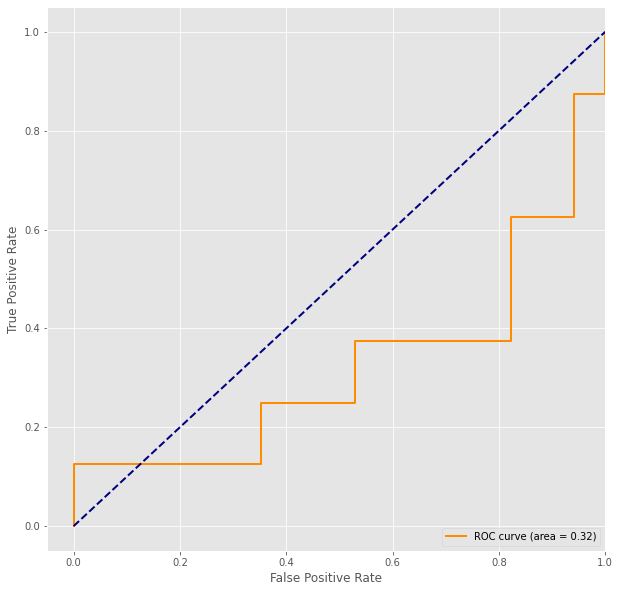

Metrics with size 100, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


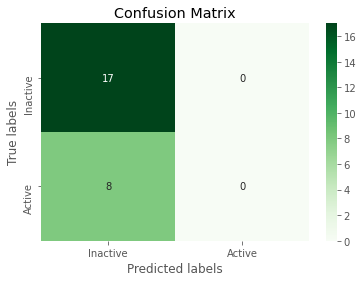

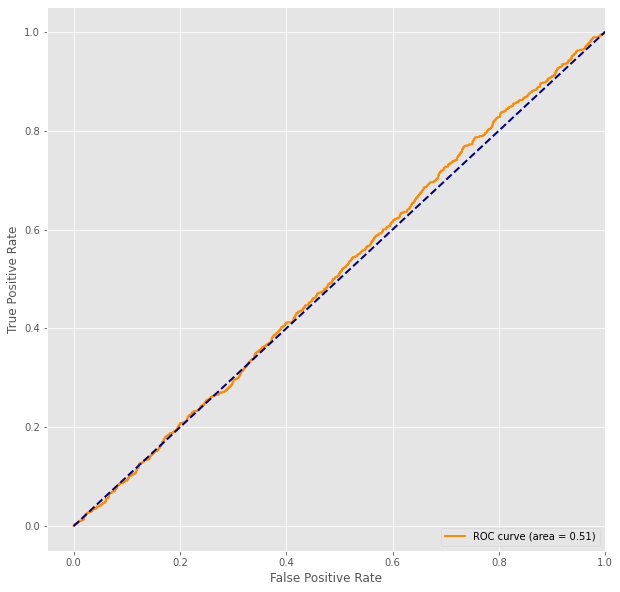

Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 300, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


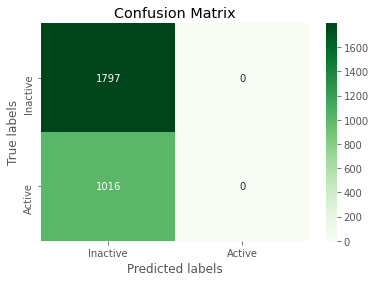

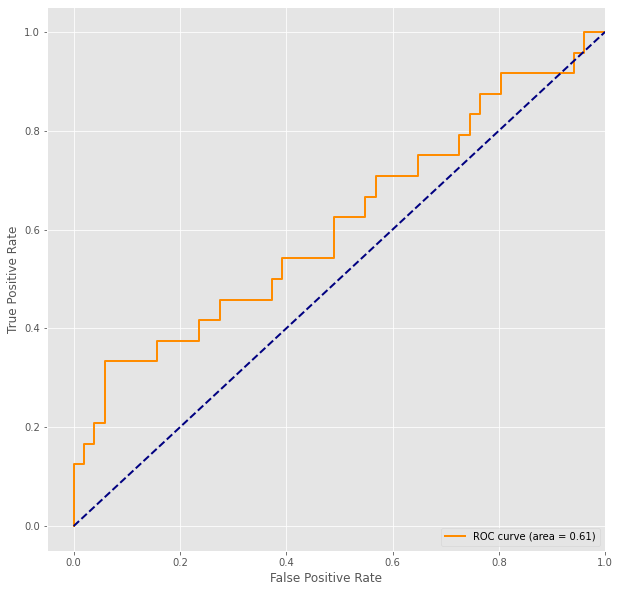

Metrics with size 300, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


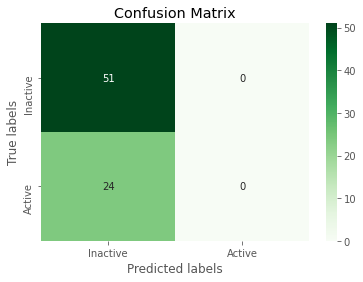

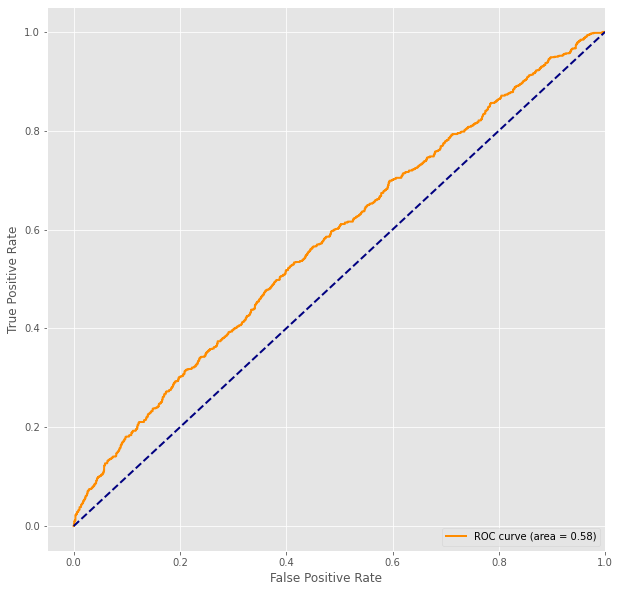

Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 500, testing set
NER: 0.744, Sensitivity or recall: 0.700, Specificity: 0.788, Precision: 0.609, Correctly classified: 0.760, MCC: 0.472


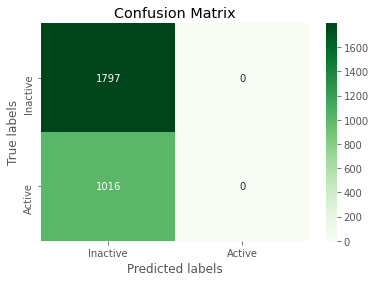

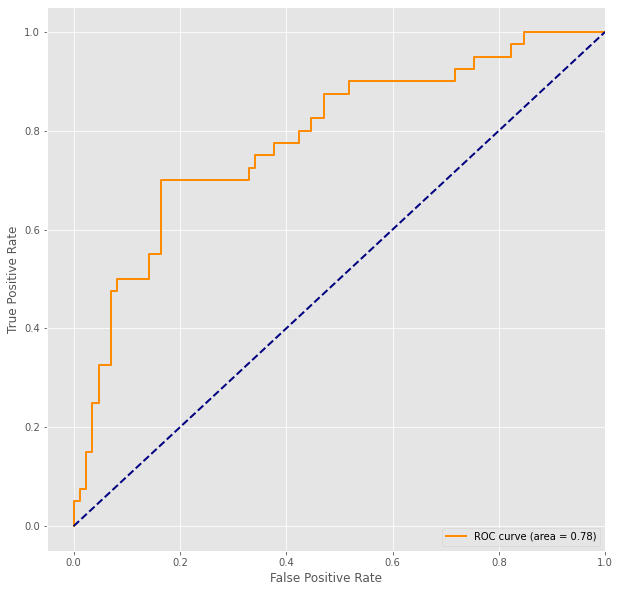

Metrics with size 500, validation set
NER: 0.629, Sensitivity or recall: 0.464, Specificity: 0.794, Precision: 0.559, Correctly classified: 0.674, MCC: 0.270


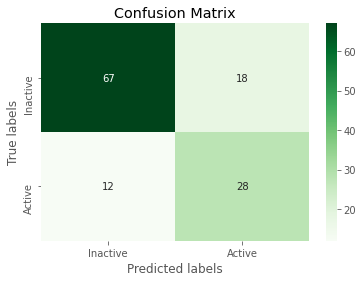

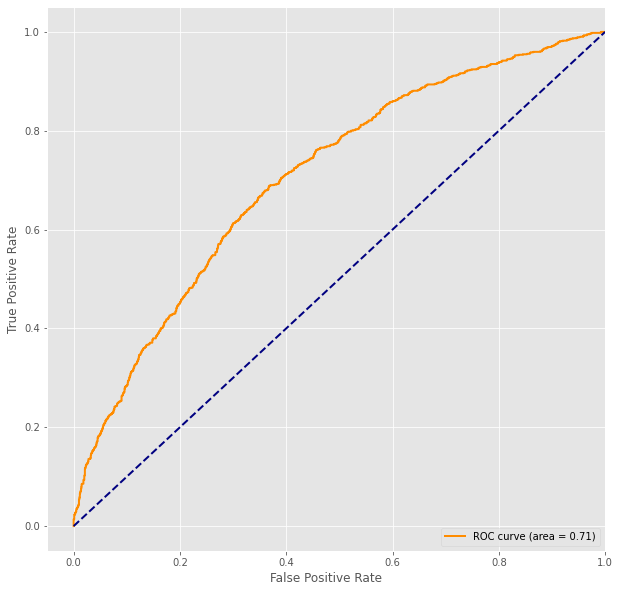

Proportion actives in test: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, testing set
NER: 0.643, Sensitivity or recall: 0.359, Specificity: 0.926, Precision: 0.697, Correctly classified: 0.745, MCC: 0.359


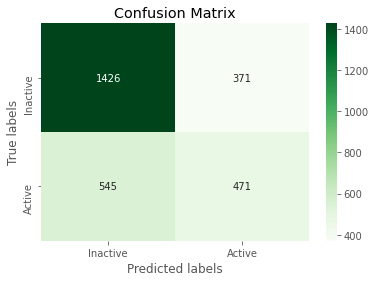

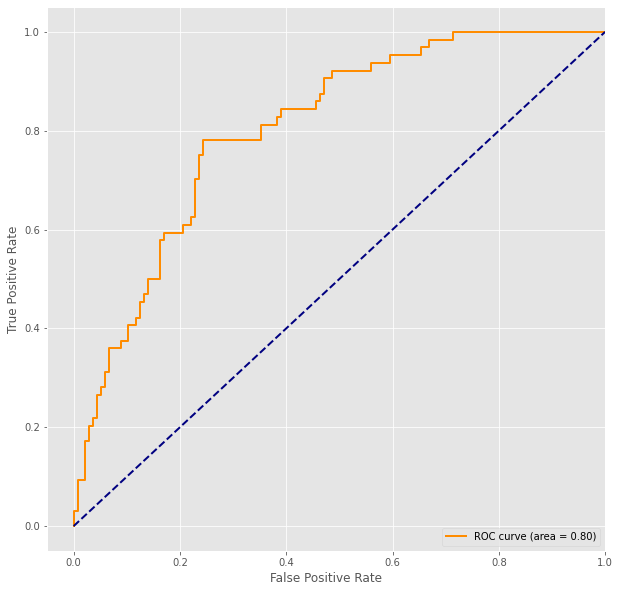

Metrics with size 800, validation set
NER: 0.615, Sensitivity or recall: 0.322, Specificity: 0.908, Precision: 0.663, Correctly classified: 0.696, MCC: 0.290


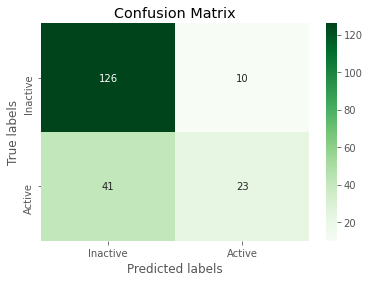

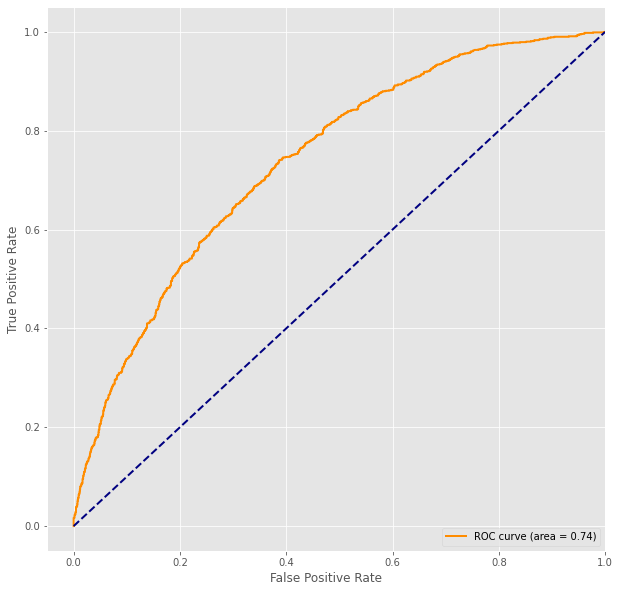

Proportion actives in test: 0.32 Proportion actives in train: 0.32133333333333336
Metrics with size 1000, testing set
NER: 0.750, Sensitivity or recall: 0.613, Specificity: 0.888, Precision: 0.721, Correctly classified: 0.800, MCC: 0.525


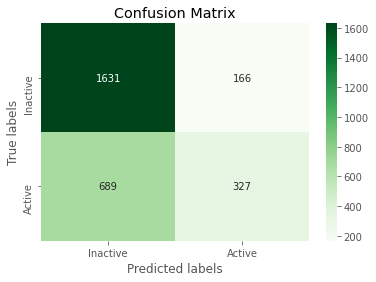

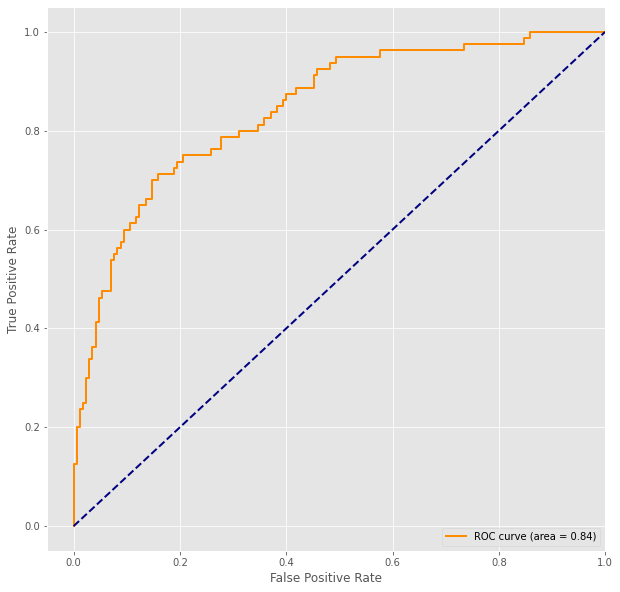

Metrics with size 1000, validation set
NER: 0.660, Sensitivity or recall: 0.499, Specificity: 0.820, Precision: 0.611, Correctly classified: 0.704, MCC: 0.336


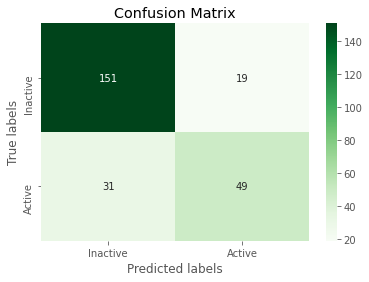

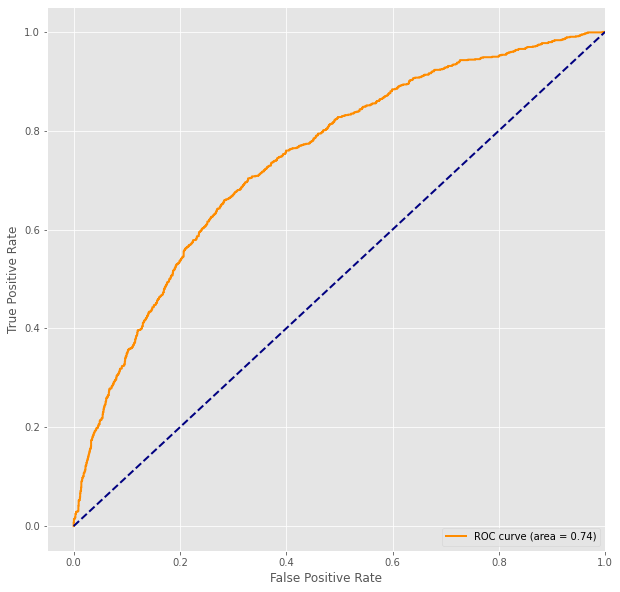

Proportion actives in test: 0.32266666666666666 Proportion actives in train: 0.3208888888888889
Metrics with size 1500, testing set
NER: 0.729, Sensitivity or recall: 0.521, Specificity: 0.937, Precision: 0.797, Correctly classified: 0.803, MCC: 0.525


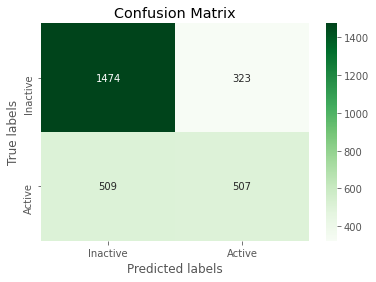

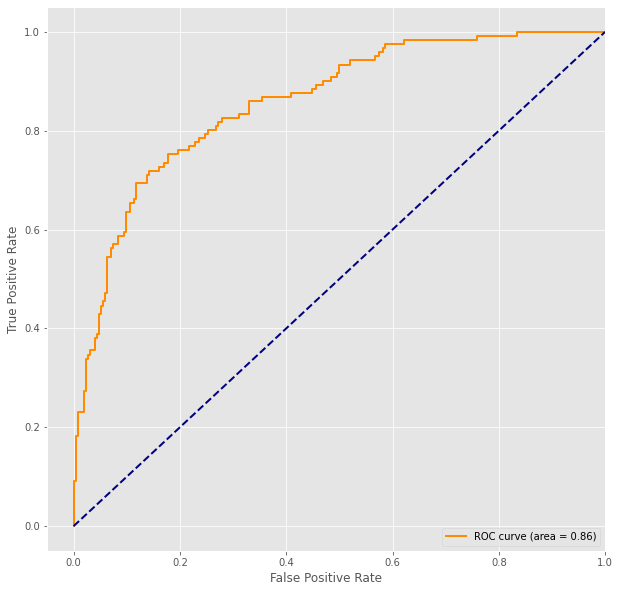

Metrics with size 1500, validation set
NER: 0.631, Sensitivity or recall: 0.349, Specificity: 0.912, Precision: 0.692, Correctly classified: 0.709, MCC: 0.325


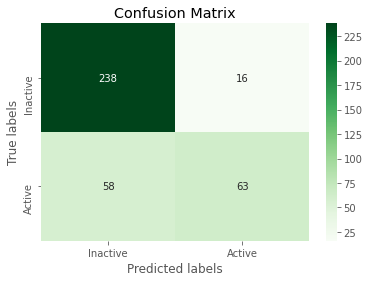

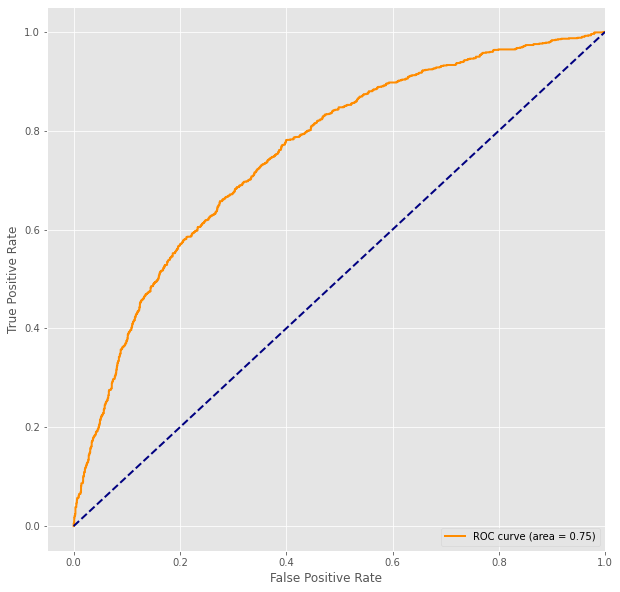

Proportion actives in test: 0.322 Proportion actives in train: 0.32133333333333336
Metrics with size 2000, testing set
NER: 0.795, Sensitivity or recall: 0.714, Specificity: 0.876, Precision: 0.732, Correctly classified: 0.824, MCC: 0.594


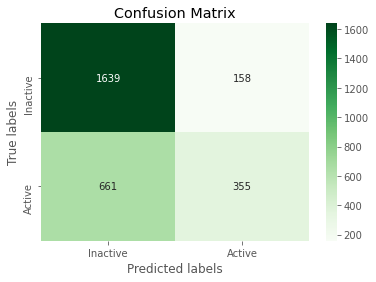

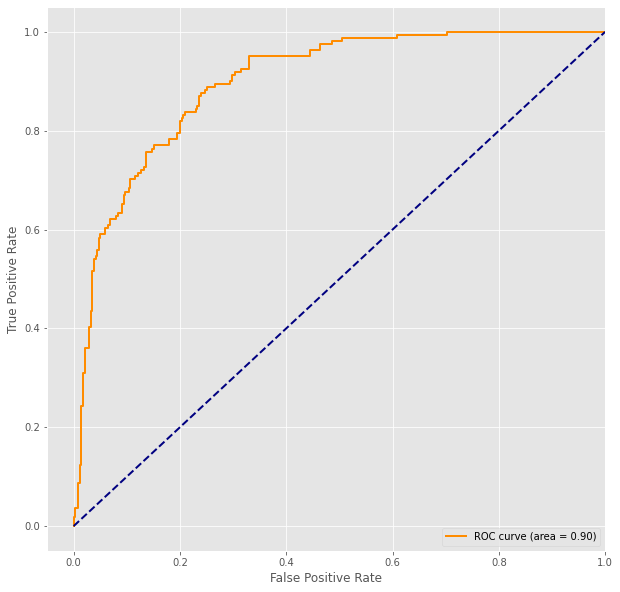

Metrics with size 2000, validation set
NER: 0.701, Sensitivity or recall: 0.578, Specificity: 0.825, Precision: 0.651, Correctly classified: 0.736, MCC: 0.414


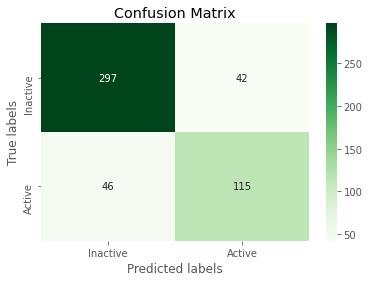

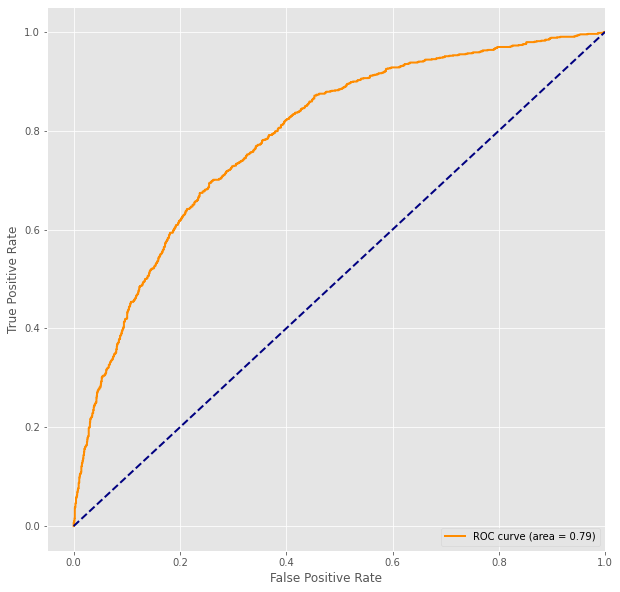

Proportion actives in test: 0.32133333333333336 Proportion actives in train: 0.32133333333333336
Metrics with size 3000, testing set
NER: 0.796, Sensitivity or recall: 0.680, Specificity: 0.912, Precision: 0.785, Correctly classified: 0.837, MCC: 0.617


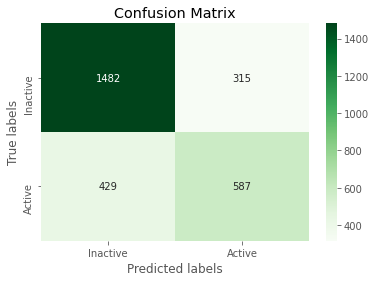

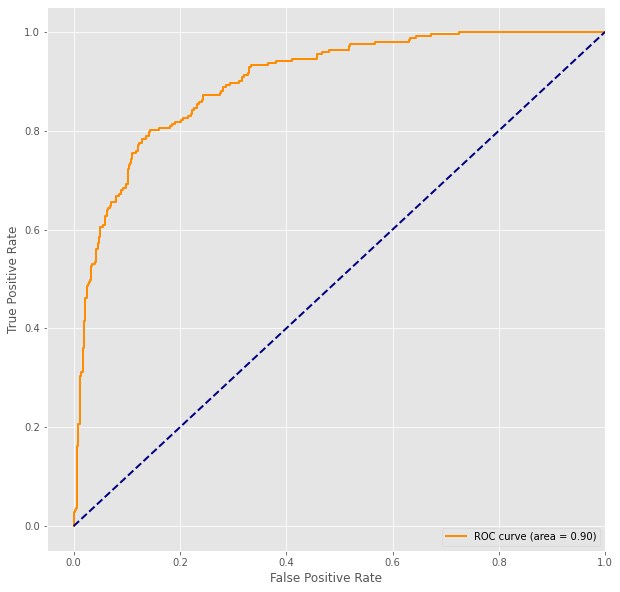

Metrics with size 3000, validation set
NER: 0.685, Sensitivity or recall: 0.518, Specificity: 0.853, Precision: 0.665, Correctly classified: 0.732, MCC: 0.396


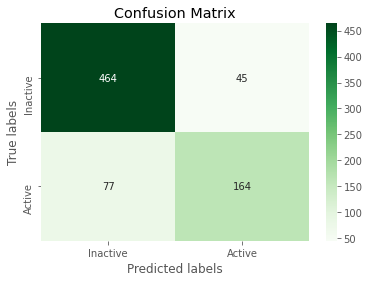

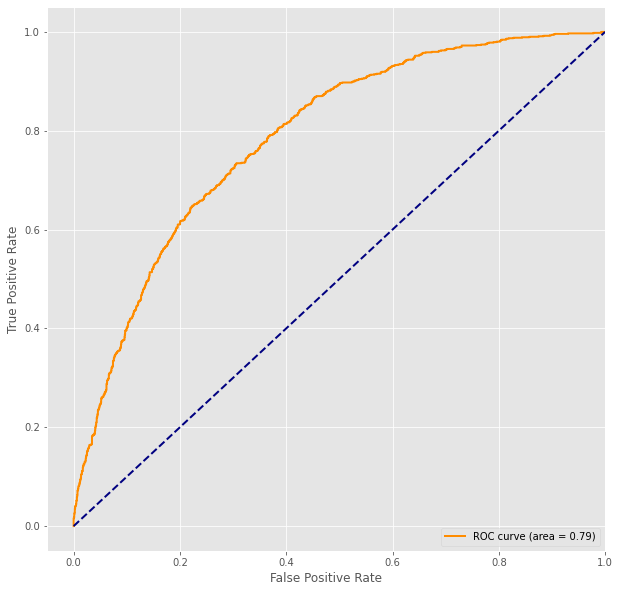

Proportion actives in test: 0.3216 Proportion actives in train: 0.32133333333333336
Metrics with size 5000, testing set
NER: 0.861, Sensitivity or recall: 0.841, Specificity: 0.882, Precision: 0.772, Correctly classified: 0.869, MCC: 0.708


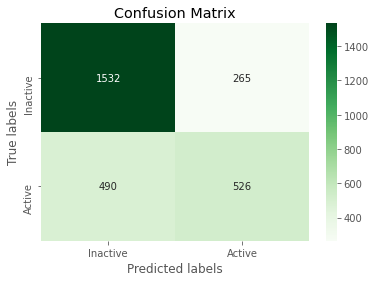

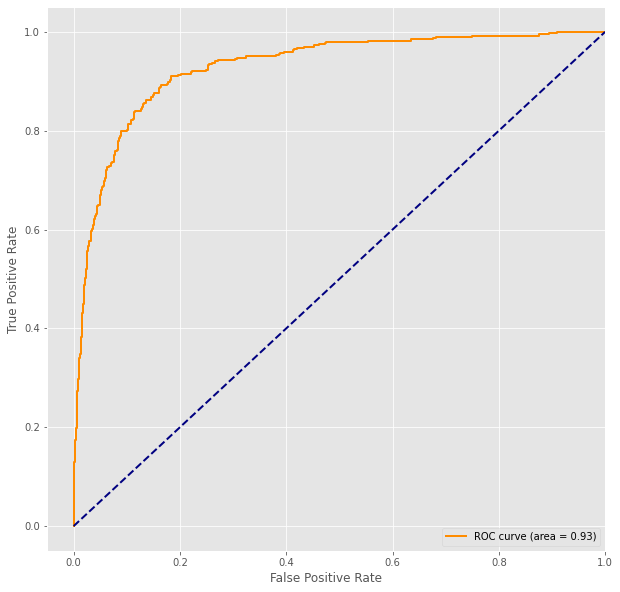

Metrics with size 5000, validation set
NER: 0.736, Sensitivity or recall: 0.665, Specificity: 0.806, Precision: 0.660, Correctly classified: 0.755, MCC: 0.470


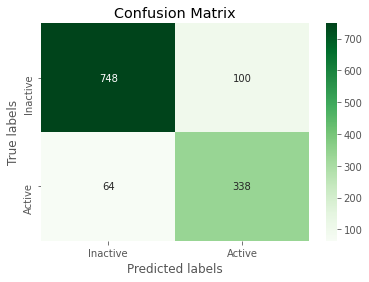

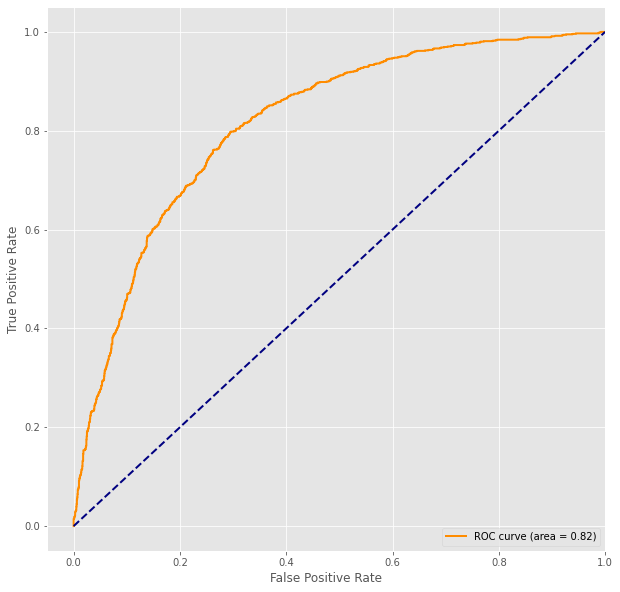

Proportion actives in test: 0.3211428571428571 Proportion actives in train: 0.32152380952380955
Metrics with size 7000, testing set
NER: 0.890, Sensitivity or recall: 0.822, Specificity: 0.959, Precision: 0.904, Correctly classified: 0.915, MCC: 0.802


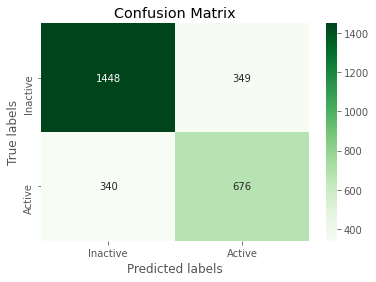

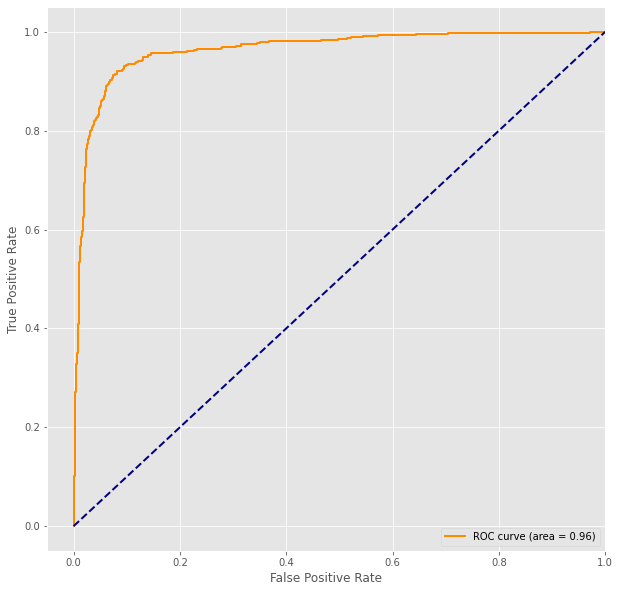

Metrics with size 7000, validation set
NER: 0.706, Sensitivity or recall: 0.534, Specificity: 0.878, Precision: 0.712, Correctly classified: 0.754, MCC: 0.445


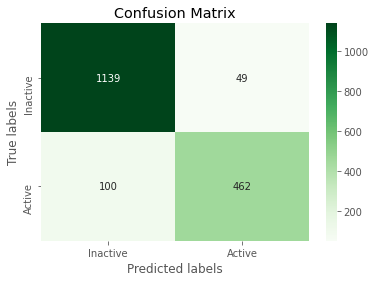

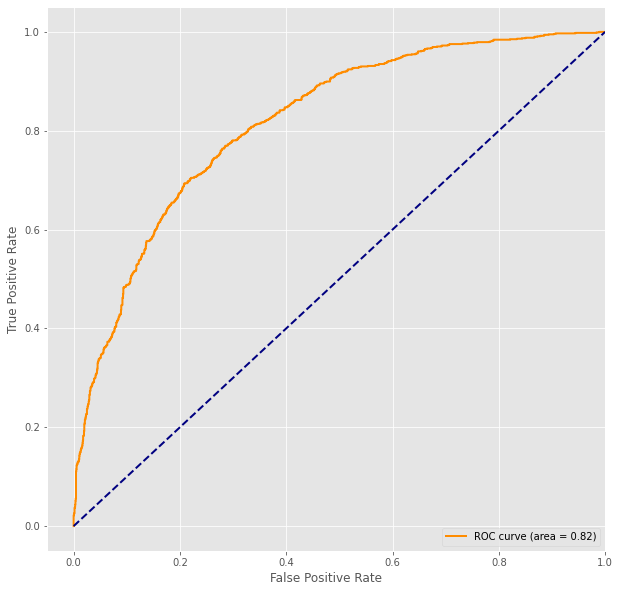

Proportion actives in test: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, testing set
NER: 0.941, Sensitivity or recall: 0.930, Specificity: 0.952, Precision: 0.901, Correctly classified: 0.945, MCC: 0.875


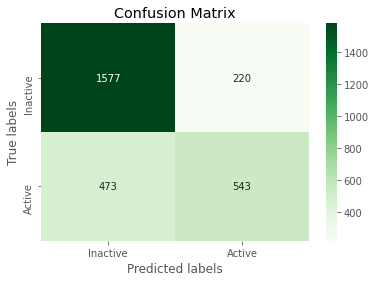

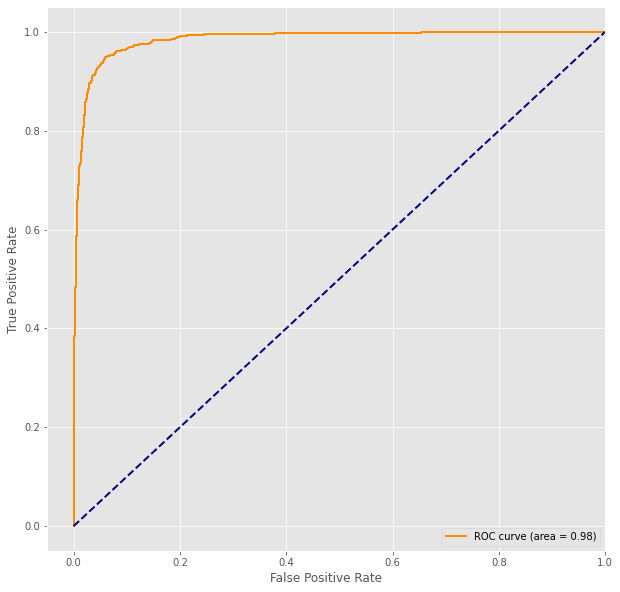

Metrics with size 9420, validation set
NER: 0.729, Sensitivity or recall: 0.646, Specificity: 0.813, Precision: 0.661, Correctly classified: 0.753, MCC: 0.461


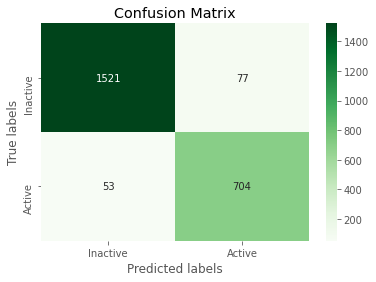

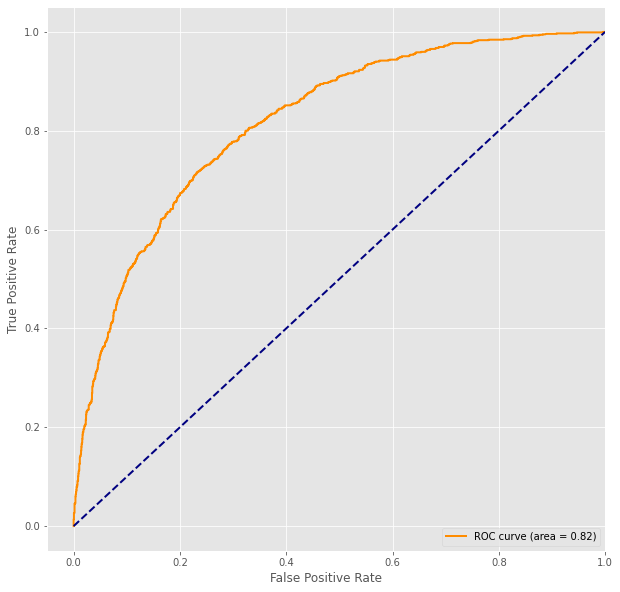

In [33]:
sizes = [100, 300, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
isoform_name = "2c9"
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,)),tf.keras.layers.Dropout(dropout)]+
    [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
# non-balanced, 2c9 set
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path, isoform_name, labels_2c9, features_shared, features_only_2c9, labels_validation_2c9, "nonbalanced")

Proportion actives in test: 0.52 Proportion actives in train: 0.49333333333333335
Metrics with size 100, testing set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.520, Correctly classified: 0.520, MCC: nan


<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


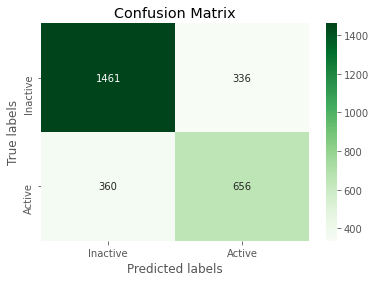

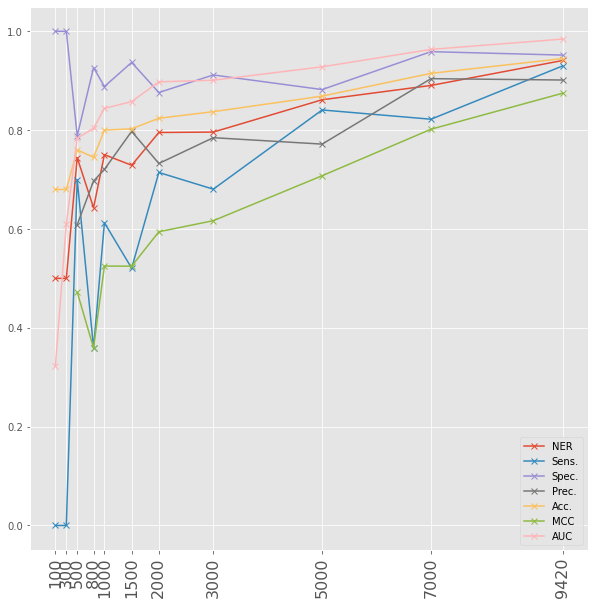

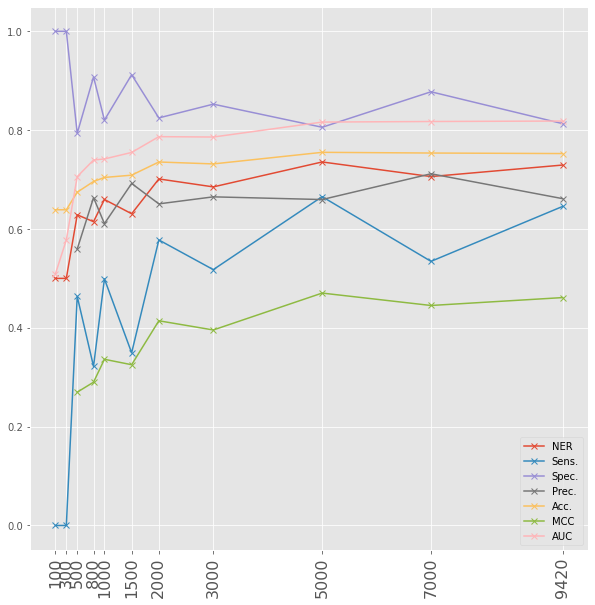

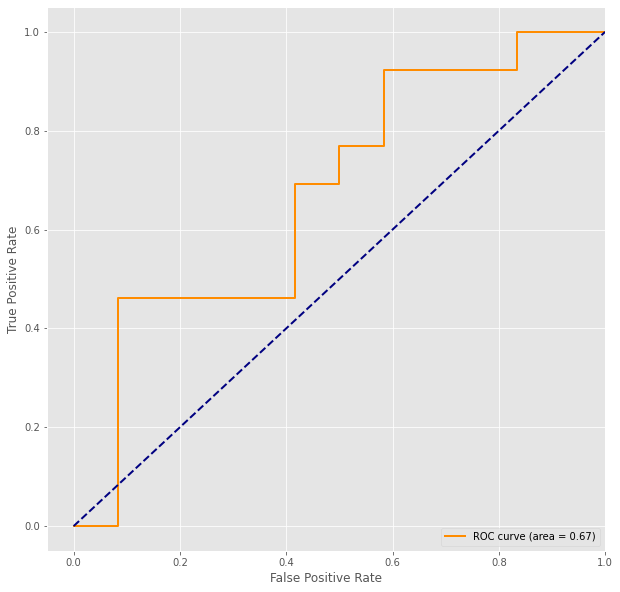

Metrics with size 100, validation set
NER: 0.502, Sensitivity or recall: 0.998, Specificity: 0.005, Precision: 0.362, Correctly classified: 0.364, MCC: 0.023


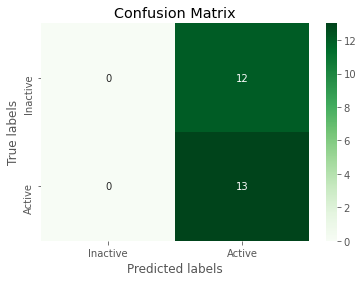

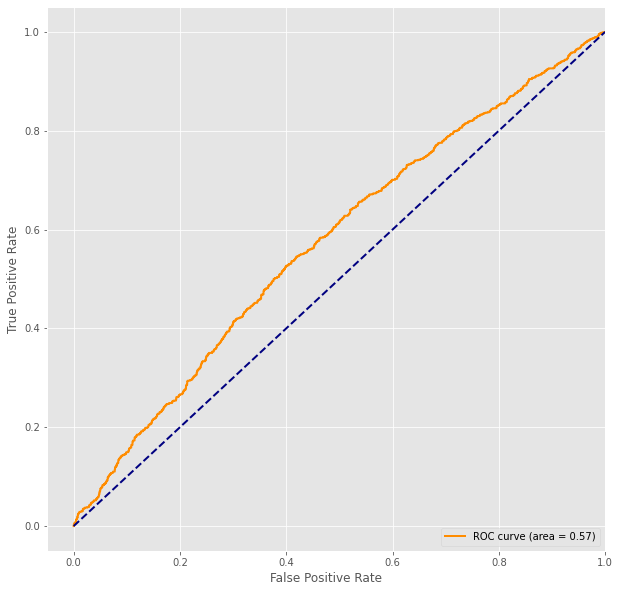

Proportion actives in test: 0.5066666666666667 Proportion actives in train: 0.49777777777777776
Metrics with size 300, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.493, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


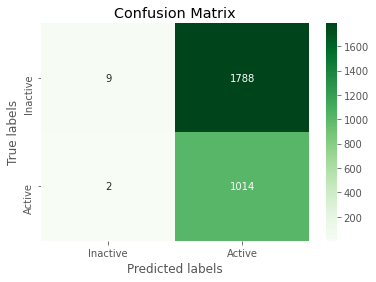

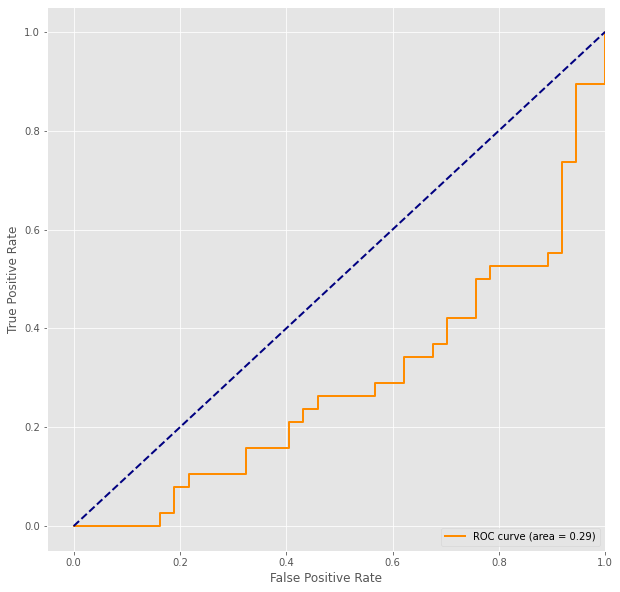

Metrics with size 300, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


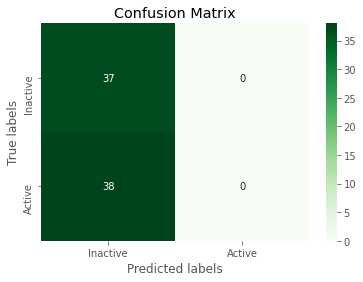

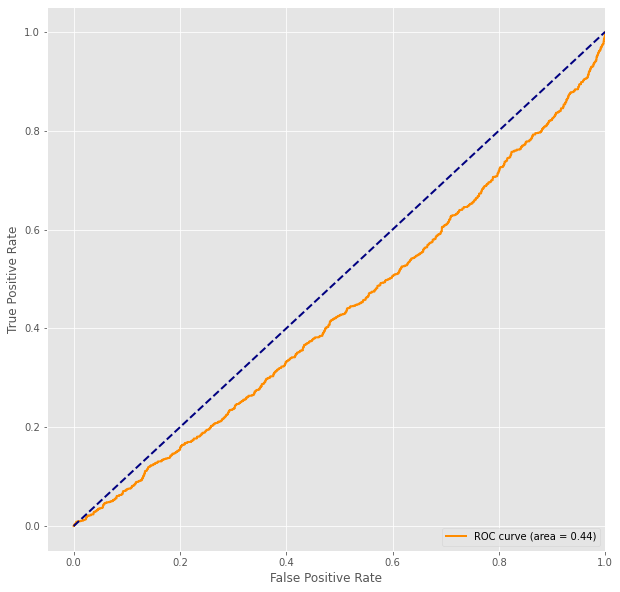

Proportion actives in test: 0.496 Proportion actives in train: 0.5013333333333333
Metrics with size 500, testing set
NER: 0.704, Sensitivity or recall: 0.645, Specificity: 0.762, Precision: 0.727, Correctly classified: 0.704, MCC: 0.410


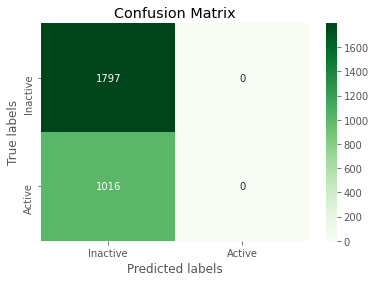

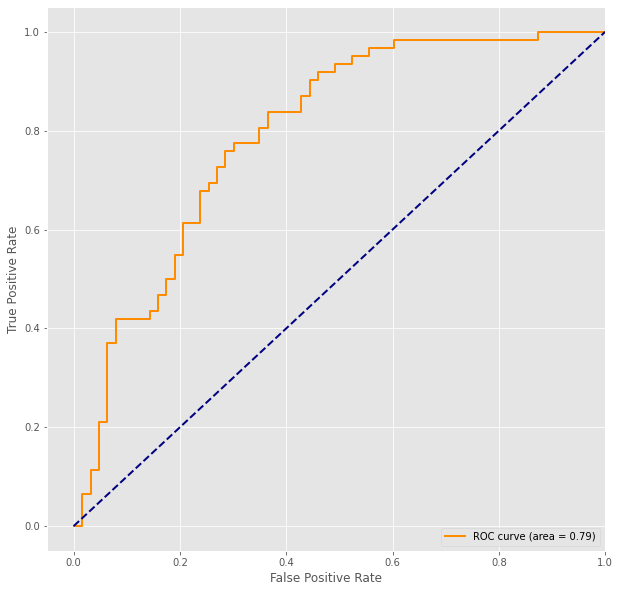

Metrics with size 500, validation set
NER: 0.639, Sensitivity or recall: 0.547, Specificity: 0.731, Precision: 0.535, Correctly classified: 0.665, MCC: 0.277


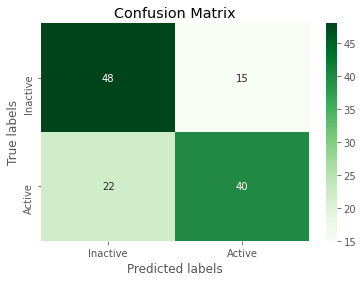

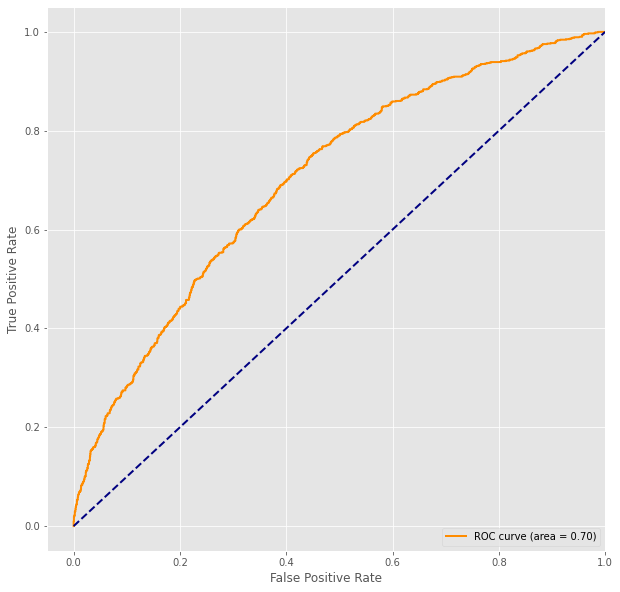

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 800, testing set
NER: 0.800, Sensitivity or recall: 0.920, Specificity: 0.680, Precision: 0.742, Correctly classified: 0.800, MCC: 0.618


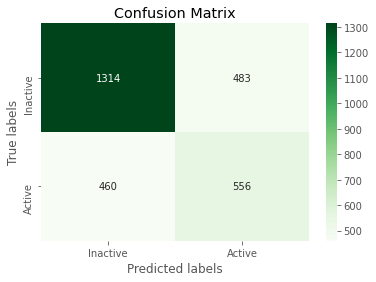

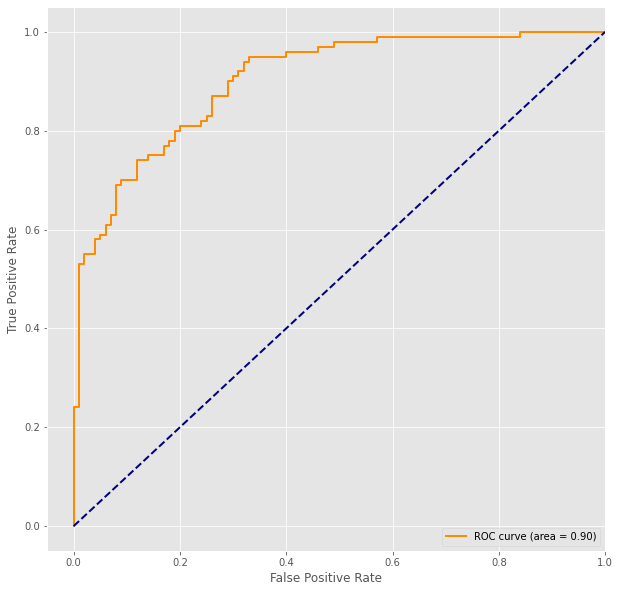

Metrics with size 800, validation set
NER: 0.680, Sensitivity or recall: 0.820, Specificity: 0.540, Precision: 0.502, Correctly classified: 0.641, MCC: 0.351


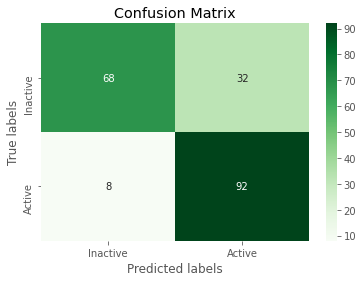

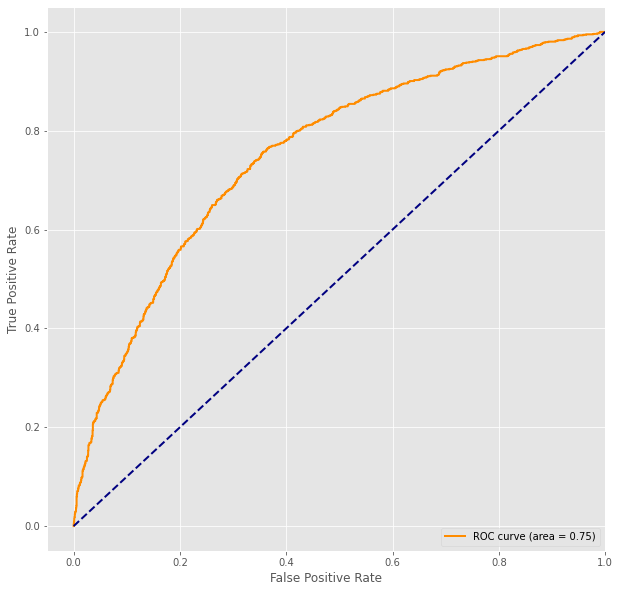

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 1000, testing set
NER: 0.756, Sensitivity or recall: 0.864, Specificity: 0.648, Precision: 0.711, Correctly classified: 0.756, MCC: 0.524


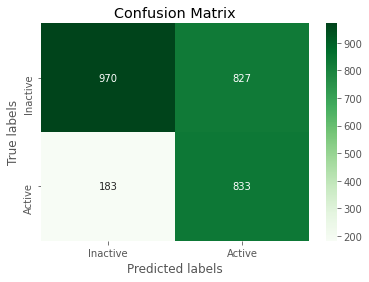

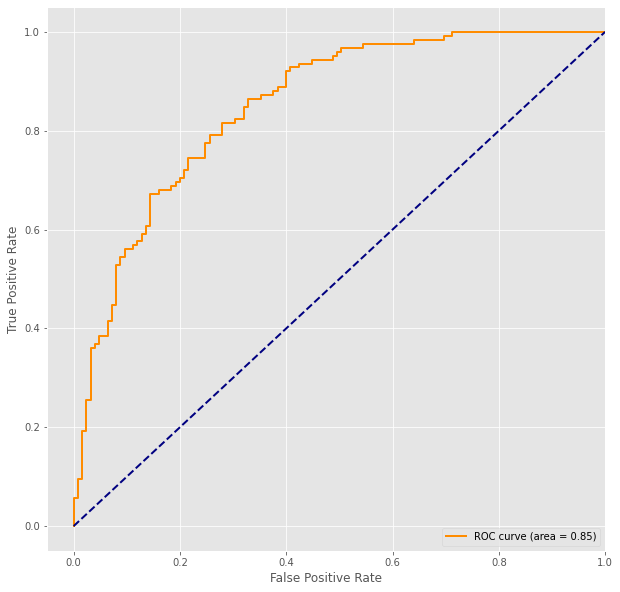

Metrics with size 1000, validation set
NER: 0.690, Sensitivity or recall: 0.763, Specificity: 0.617, Precision: 0.529, Correctly classified: 0.669, MCC: 0.365


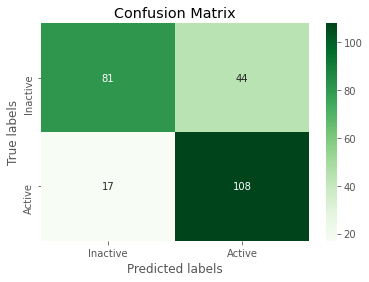

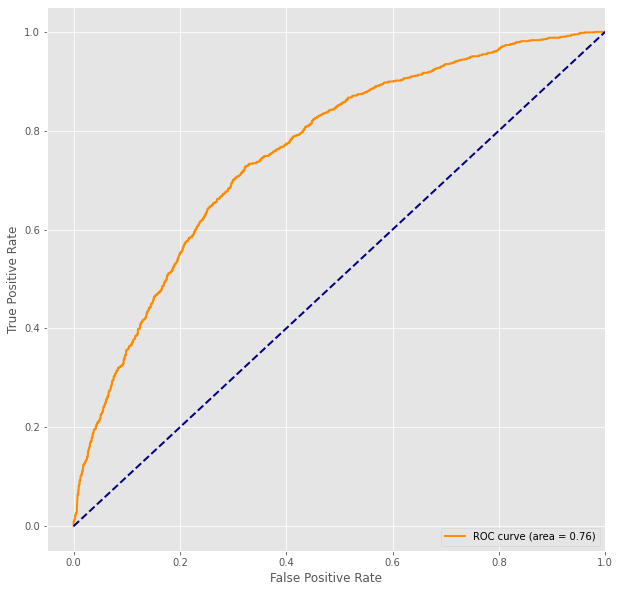

Proportion actives in test: 0.49866666666666665 Proportion actives in train: 0.5004444444444445
Metrics with size 1500, testing set
NER: 0.628, Sensitivity or recall: 0.262, Specificity: 0.995, Precision: 0.980, Correctly classified: 0.629, MCC: 0.378


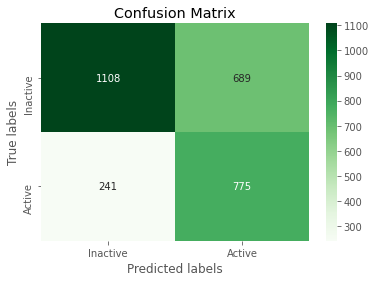

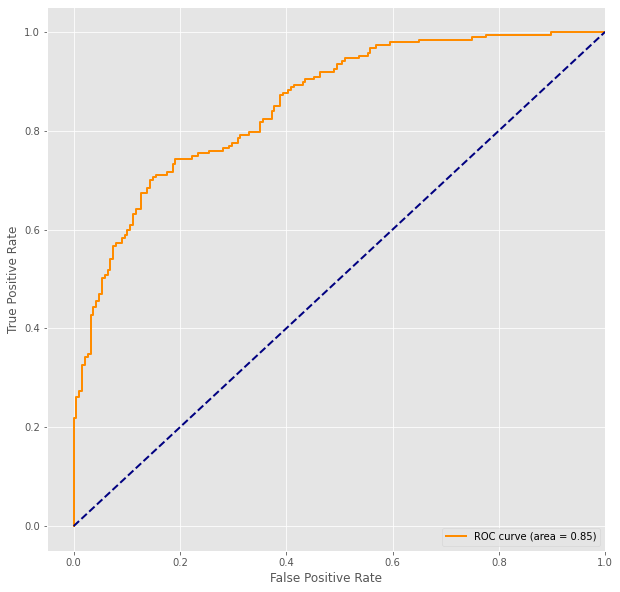

Metrics with size 1500, validation set
NER: 0.561, Sensitivity or recall: 0.155, Specificity: 0.967, Precision: 0.724, Correctly classified: 0.673, MCC: 0.218


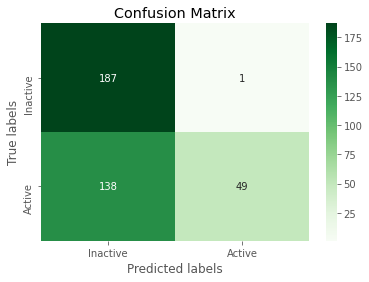

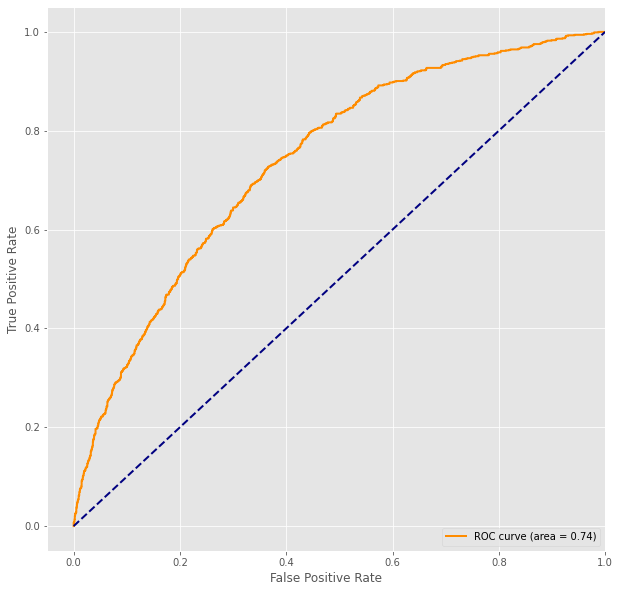

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 2000, testing set
NER: 0.786, Sensitivity or recall: 0.736, Specificity: 0.836, Precision: 0.818, Correctly classified: 0.786, MCC: 0.575


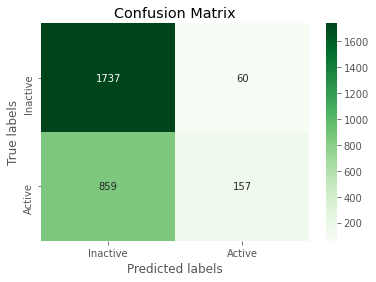

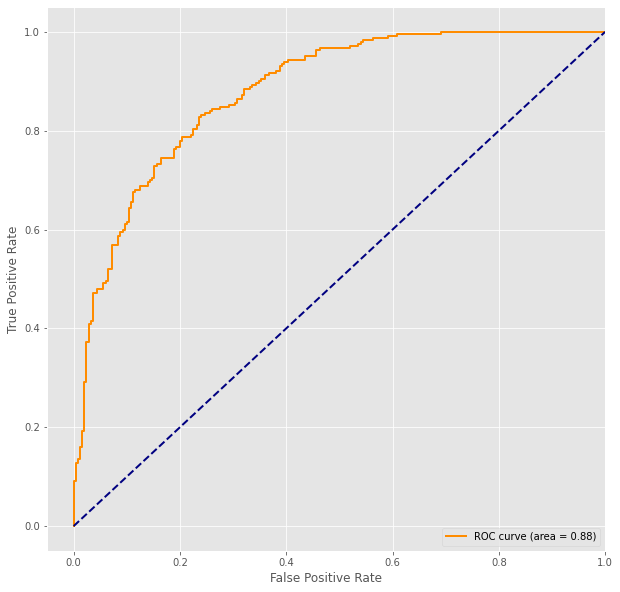

Metrics with size 2000, validation set
NER: 0.711, Sensitivity or recall: 0.665, Specificity: 0.756, Precision: 0.607, Correctly classified: 0.723, MCC: 0.414


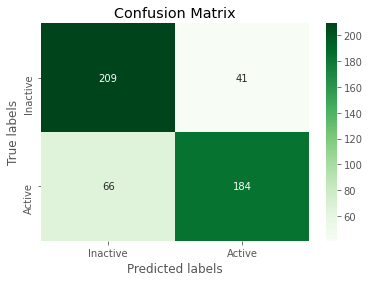

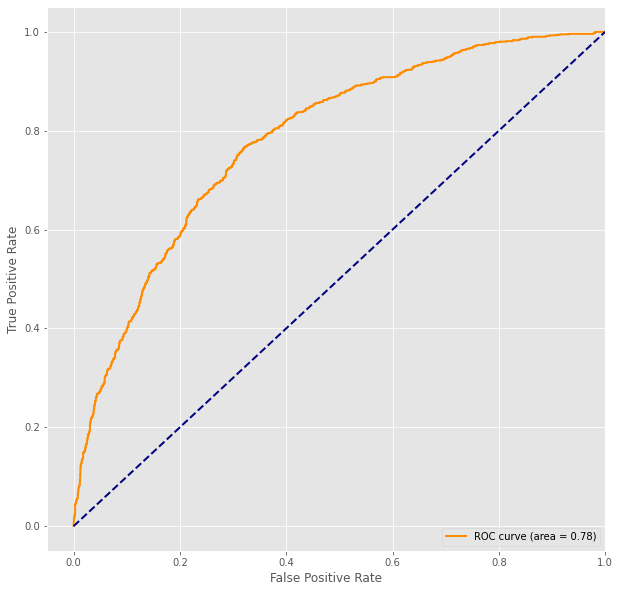

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 3000, testing set
NER: 0.847, Sensitivity or recall: 0.792, Specificity: 0.901, Precision: 0.889, Correctly classified: 0.847, MCC: 0.698


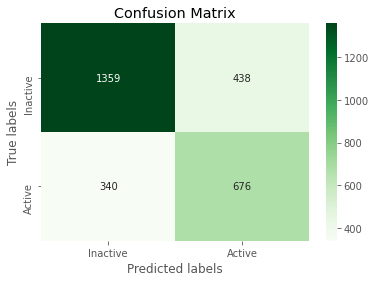

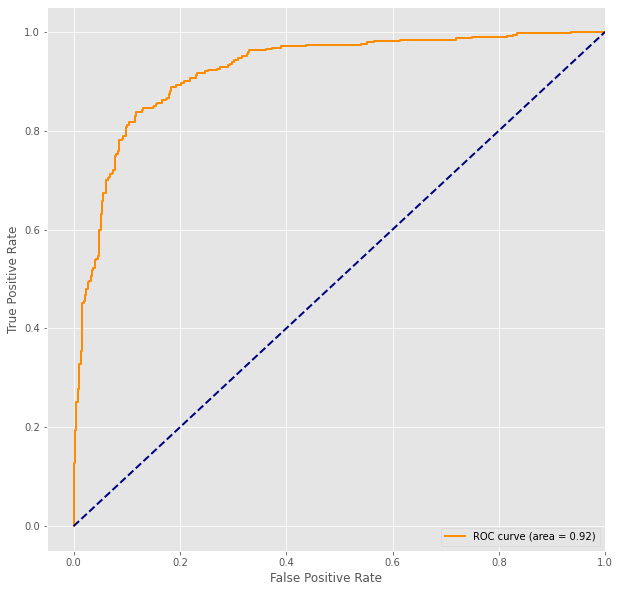

Metrics with size 3000, validation set
NER: 0.715, Sensitivity or recall: 0.616, Specificity: 0.814, Precision: 0.652, Correctly classified: 0.743, MCC: 0.436


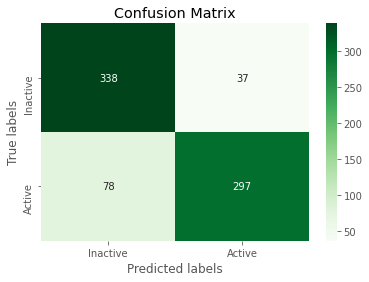

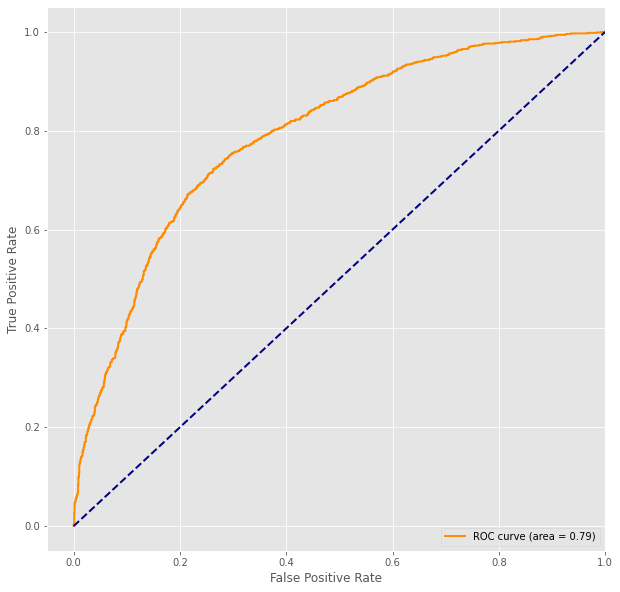

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 5000, testing set
NER: 0.873, Sensitivity or recall: 0.872, Specificity: 0.874, Precision: 0.873, Correctly classified: 0.873, MCC: 0.746


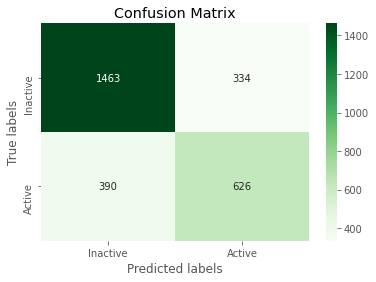

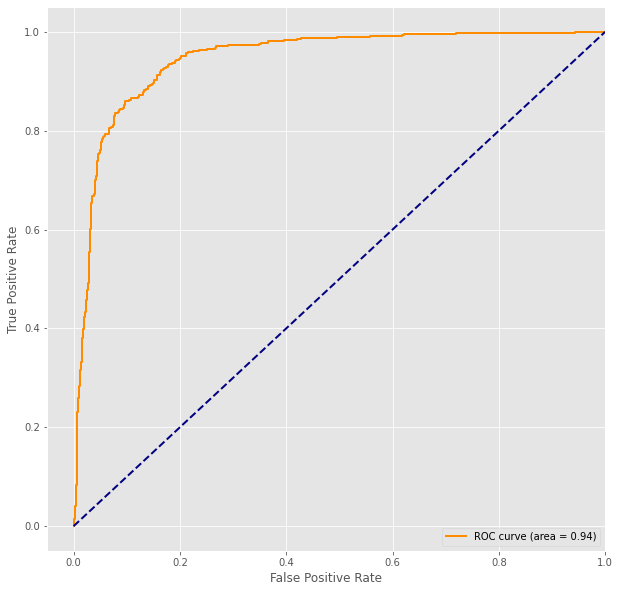

Metrics with size 5000, validation set
NER: 0.735, Sensitivity or recall: 0.702, Specificity: 0.769, Precision: 0.632, Correctly classified: 0.745, MCC: 0.461


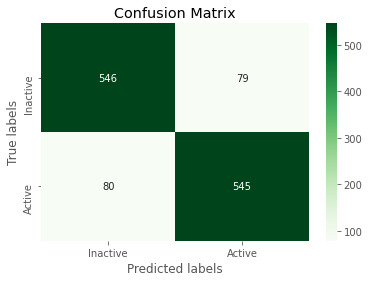

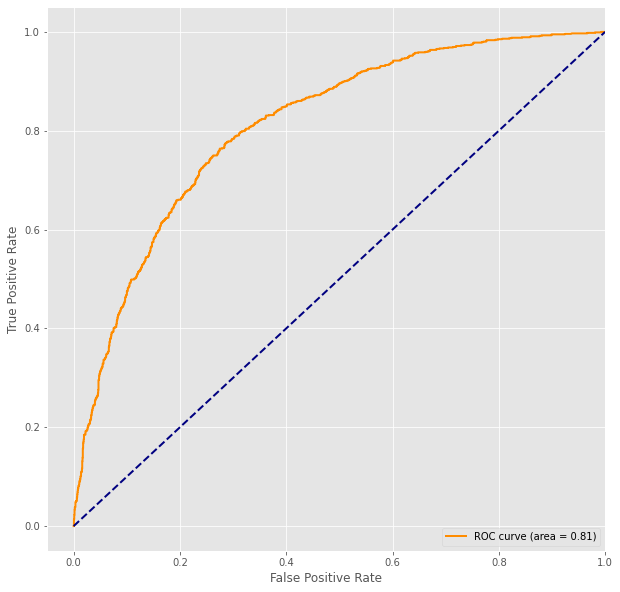

Proportion actives in test: 0.43257142857142855 Proportion actives in train: 0.43276190476190474
Metrics with size 7000, testing set
NER: 0.918, Sensitivity or recall: 0.955, Specificity: 0.880, Precision: 0.859, Correctly classified: 0.913, MCC: 0.828


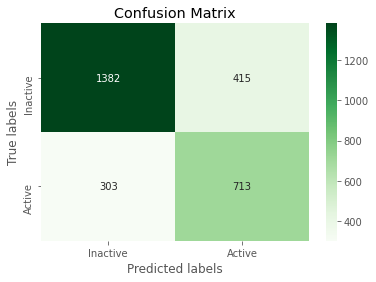

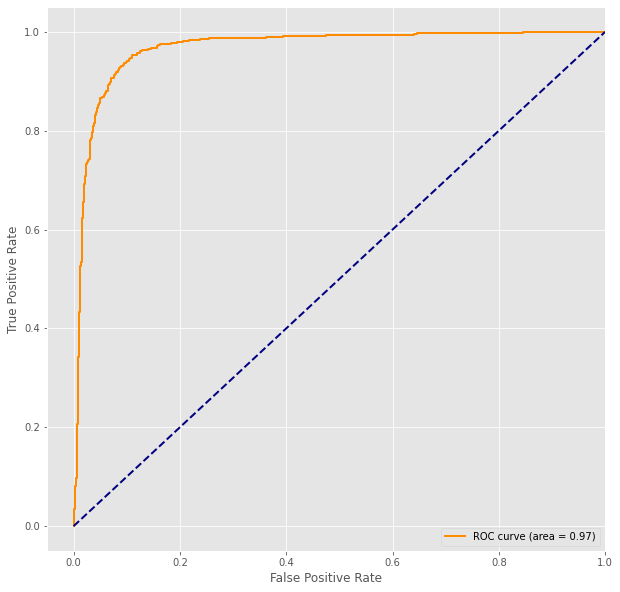

Metrics with size 7000, validation set
NER: 0.735, Sensitivity or recall: 0.750, Specificity: 0.720, Precision: 0.602, Correctly classified: 0.731, MCC: 0.454


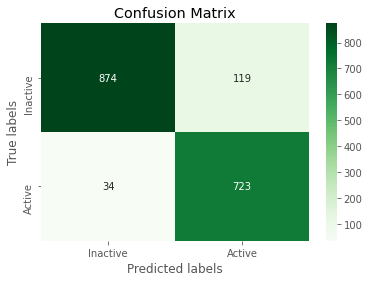

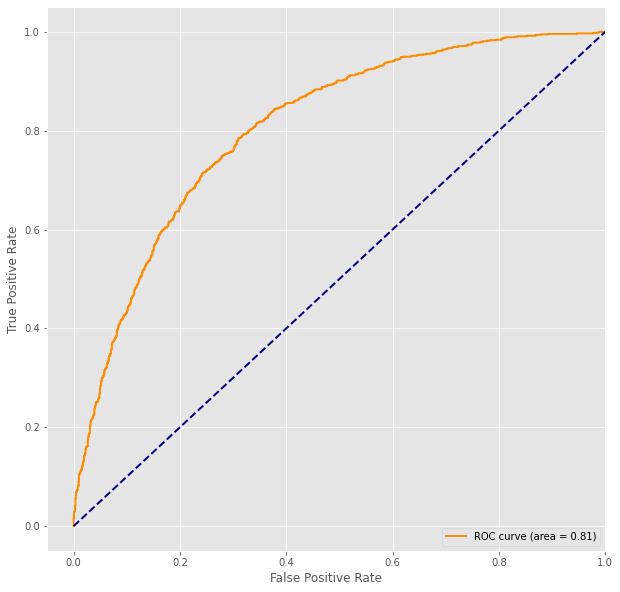

Proportion actives in test: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, testing set
NER: 0.951, Sensitivity or recall: 0.956, Specificity: 0.946, Precision: 0.894, Correctly classified: 0.949, MCC: 0.887


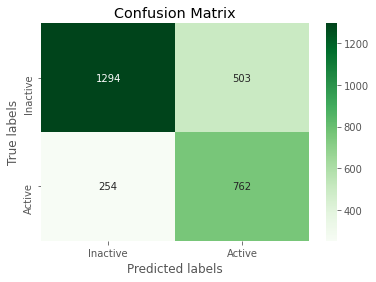

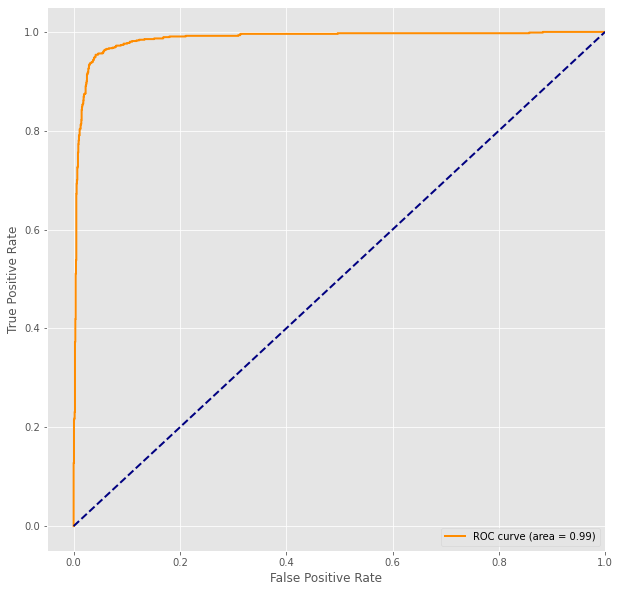

Metrics with size 9420, validation set
NER: 0.748, Sensitivity or recall: 0.696, Specificity: 0.801, Precision: 0.664, Correctly classified: 0.763, MCC: 0.492


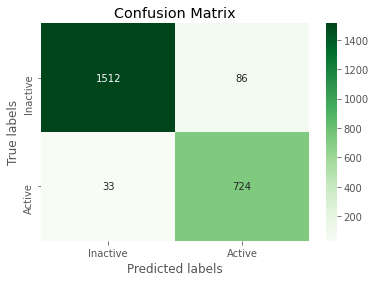

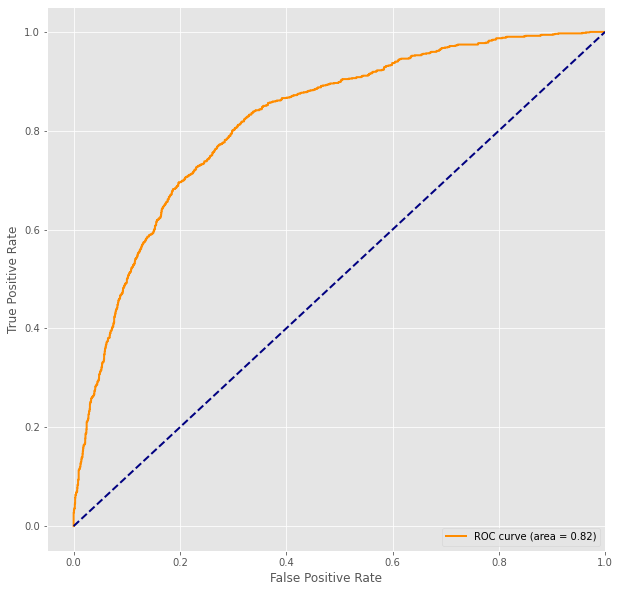

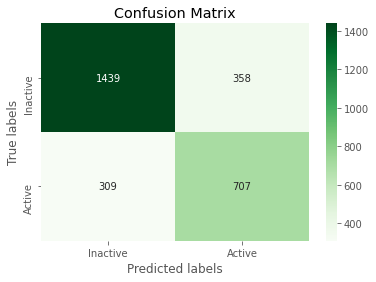

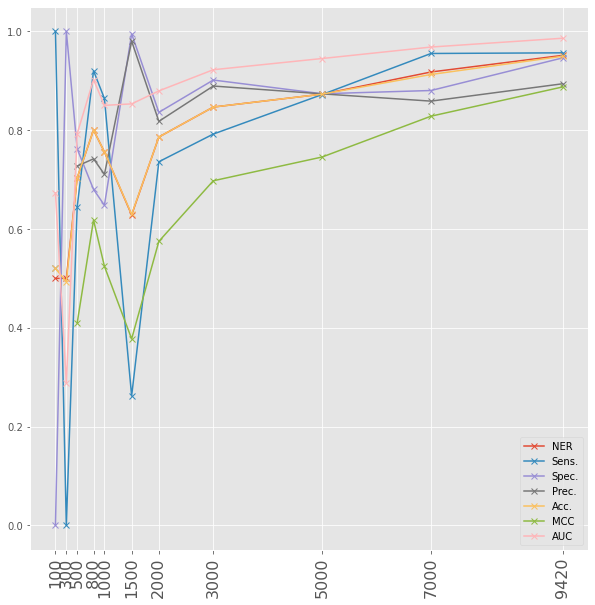

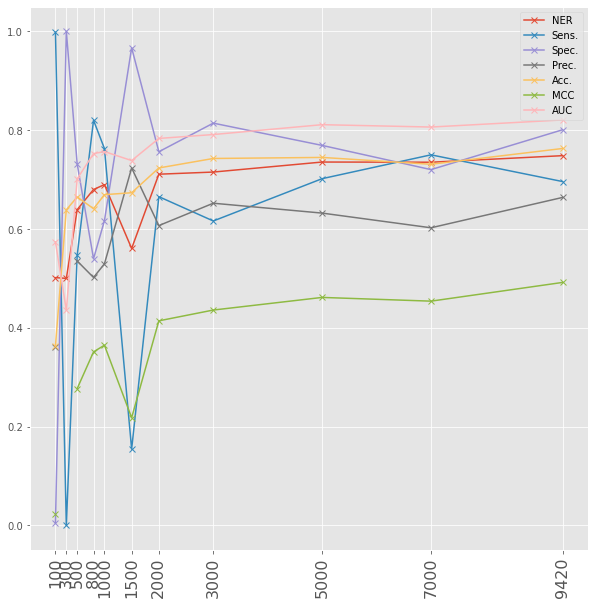

In [34]:
# balanced, 2c9 set
active_rate = 0.5
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path_balanced, isoform_name, labels_2c9, features_shared, features_only_2c9, labels_validation_2c9, "balanced")

Proportion actives in test: 0.36 Proportion actives in train: 0.38666666666666666
Metrics with size 100, testing set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.640, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


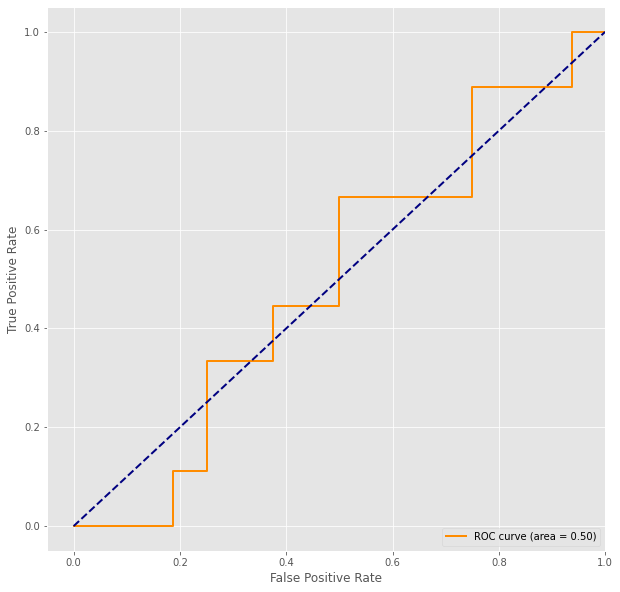

Metrics with size 100, validation set
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.510, MCC: nan


<ipython-input-29-a4ae85189bd1>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


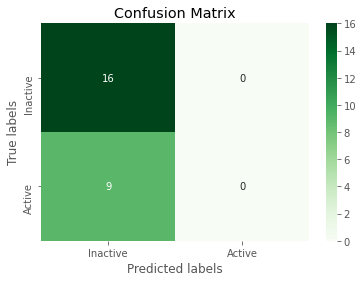

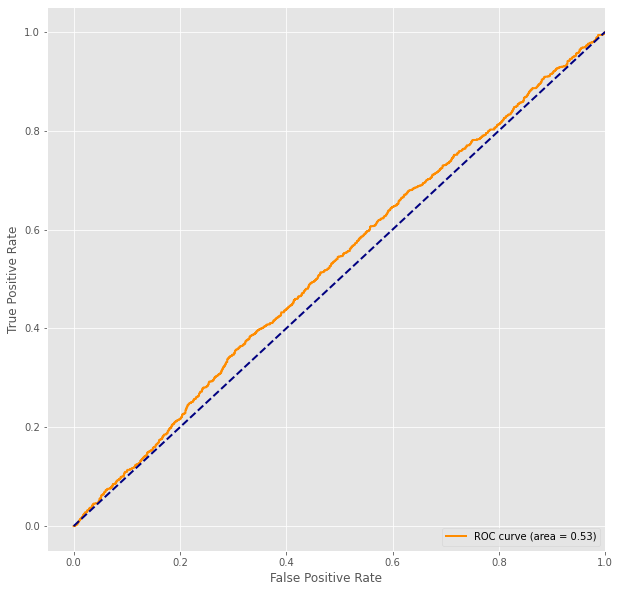

Proportion actives in test: 0.38666666666666666 Proportion actives in train: 0.38666666666666666
Metrics with size 300, testing set
NER: 0.689, Sensitivity or recall: 0.966, Specificity: 0.413, Precision: 0.509, Correctly classified: 0.627, MCC: 0.417


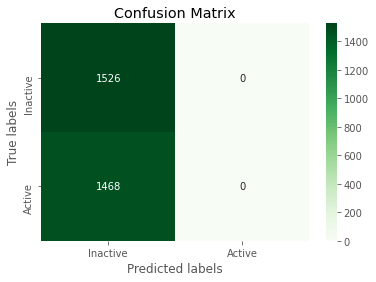

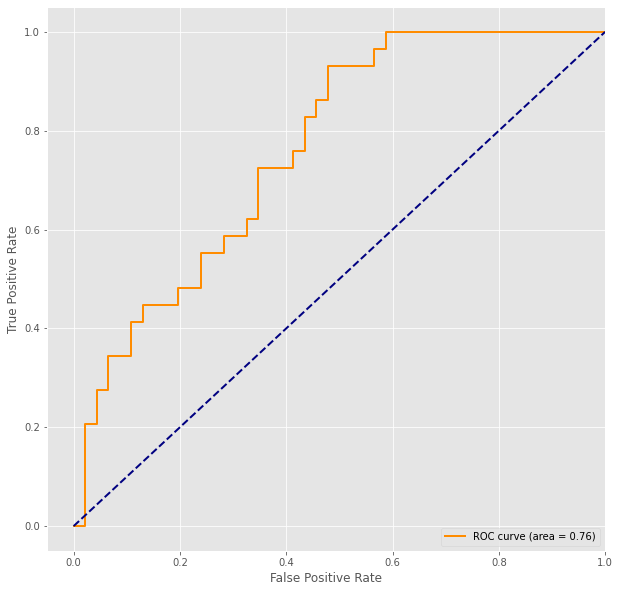

Metrics with size 300, validation set
NER: 0.598, Sensitivity or recall: 0.830, Specificity: 0.366, Precision: 0.557, Correctly classified: 0.594, MCC: 0.221


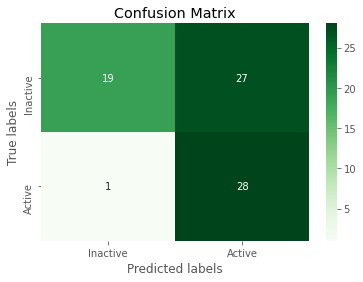

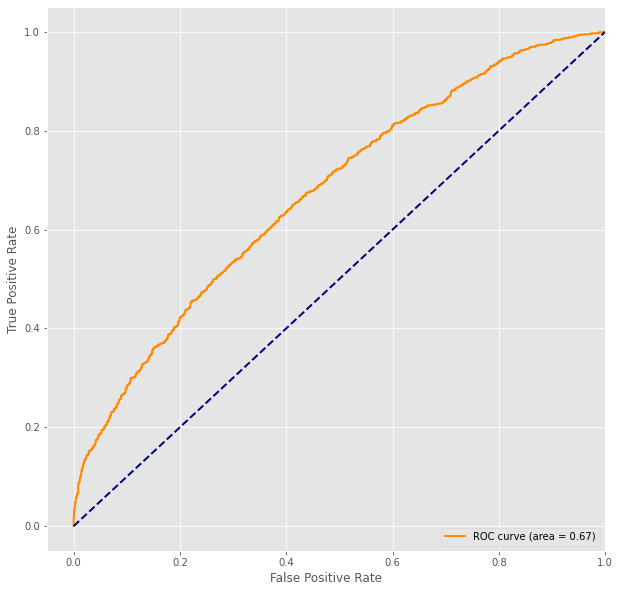

Proportion actives in test: 0.384 Proportion actives in train: 0.38666666666666666
Metrics with size 500, testing set
NER: 0.709, Sensitivity or recall: 0.625, Specificity: 0.792, Precision: 0.652, Correctly classified: 0.728, MCC: 0.421


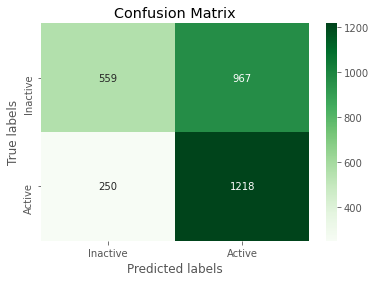

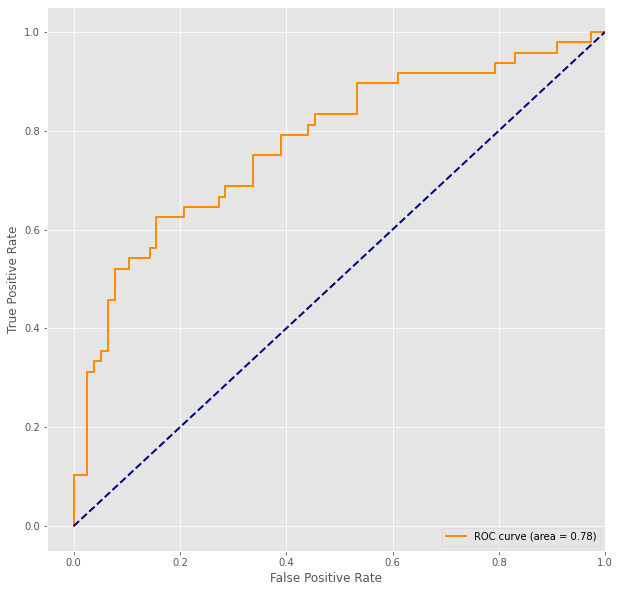

Metrics with size 500, validation set
NER: 0.641, Sensitivity or recall: 0.529, Specificity: 0.752, Precision: 0.673, Correctly classified: 0.643, MCC: 0.289


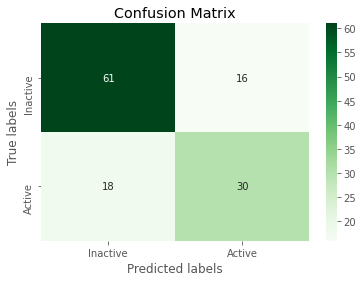

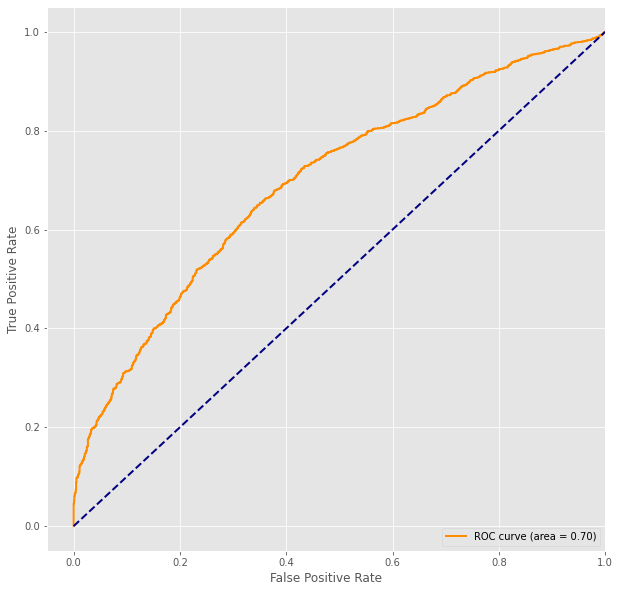

Proportion actives in test: 0.385 Proportion actives in train: 0.38666666666666666
Metrics with size 800, testing set
NER: 0.782, Sensitivity or recall: 0.792, Specificity: 0.772, Precision: 0.685, Correctly classified: 0.780, MCC: 0.553


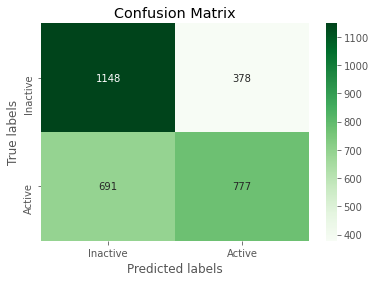

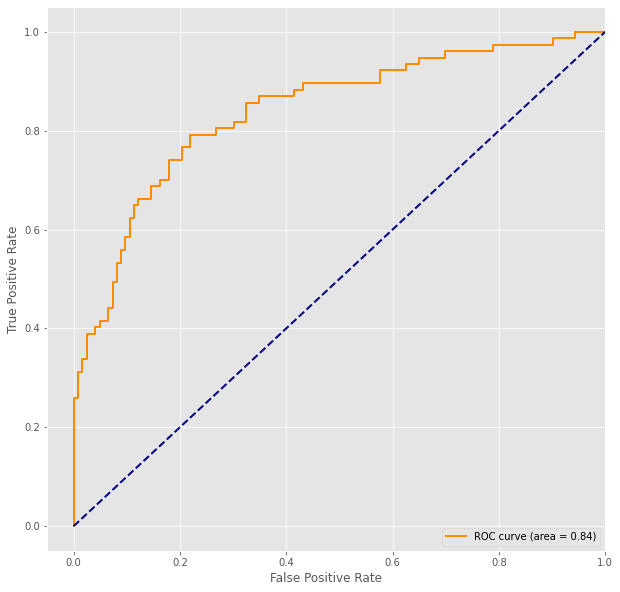

Metrics with size 800, validation set
NER: 0.672, Sensitivity or recall: 0.637, Specificity: 0.708, Precision: 0.677, Correctly classified: 0.673, MCC: 0.346


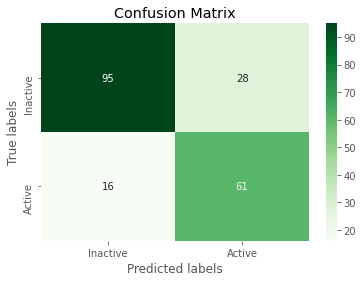

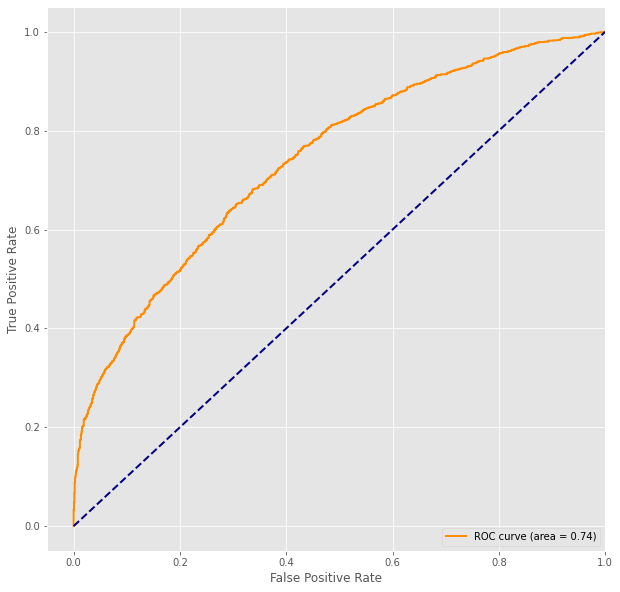

Proportion actives in test: 0.388 Proportion actives in train: 0.38666666666666666
Metrics with size 1000, testing set
NER: 0.696, Sensitivity or recall: 0.412, Specificity: 0.980, Precision: 0.930, Correctly classified: 0.760, MCC: 0.507


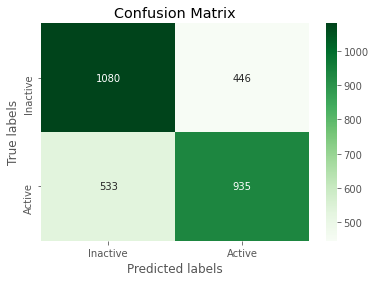

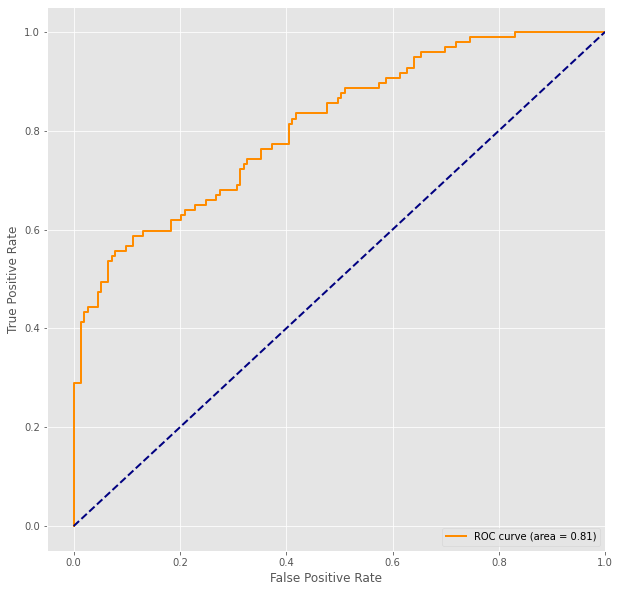

Metrics with size 1000, validation set
NER: 0.635, Sensitivity or recall: 0.332, Specificity: 0.938, Precision: 0.837, Correctly classified: 0.641, MCC: 0.340


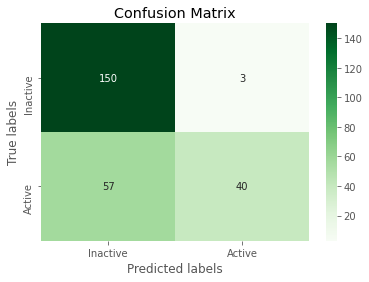

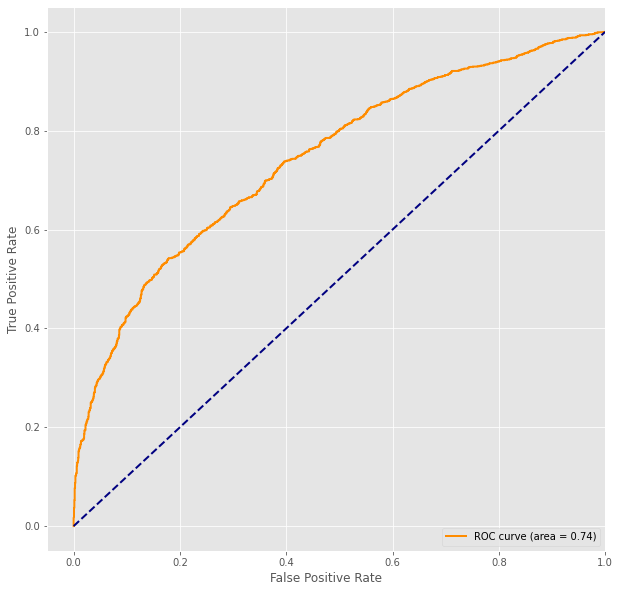

Proportion actives in test: 0.38666666666666666 Proportion actives in train: 0.38755555555555554
Metrics with size 1500, testing set
NER: 0.782, Sensitivity or recall: 0.641, Specificity: 0.922, Precision: 0.838, Correctly classified: 0.813, MCC: 0.601


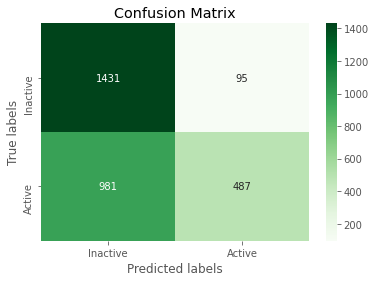

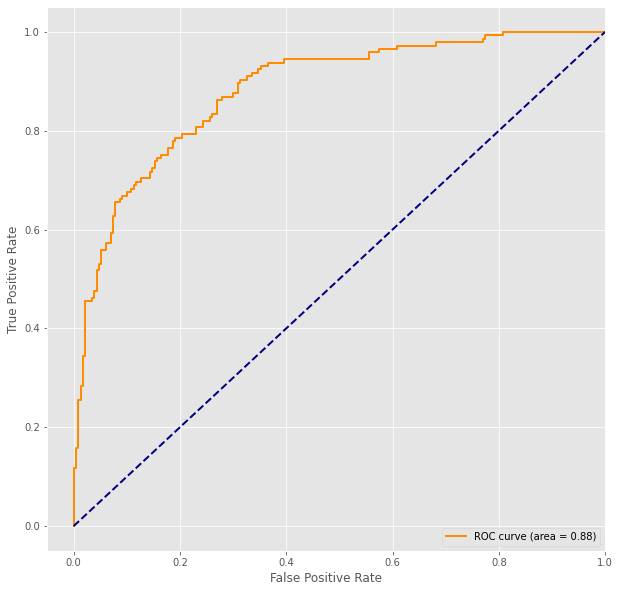

Metrics with size 1500, validation set
NER: 0.676, Sensitivity or recall: 0.501, Specificity: 0.852, Precision: 0.765, Correctly classified: 0.680, MCC: 0.378


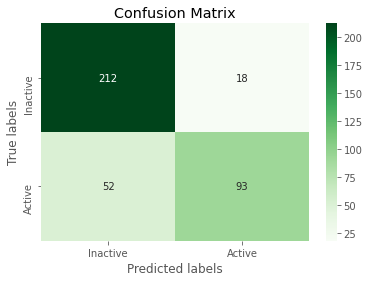

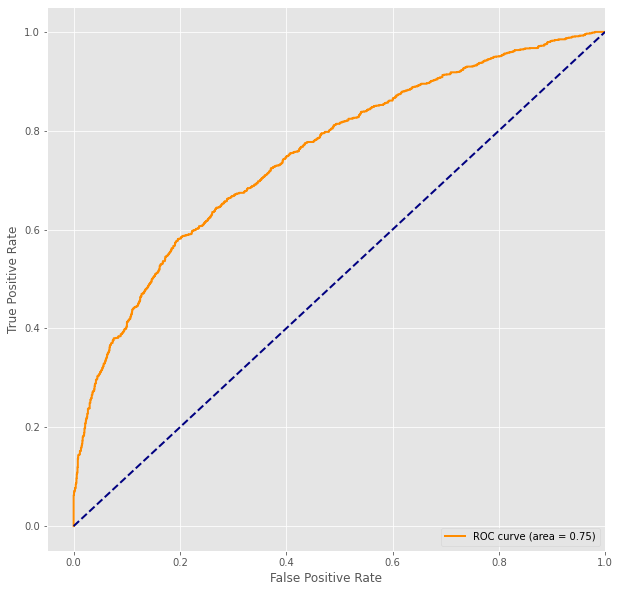

Proportion actives in test: 0.388 Proportion actives in train: 0.38666666666666666
Metrics with size 2000, testing set
NER: 0.819, Sensitivity or recall: 0.753, Specificity: 0.886, Precision: 0.807, Correctly classified: 0.834, MCC: 0.647


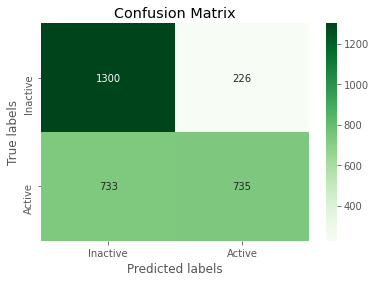

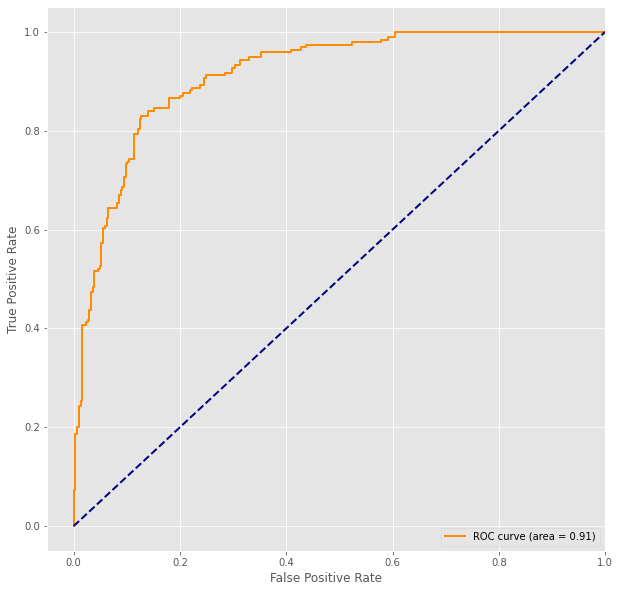

Metrics with size 2000, validation set
NER: 0.713, Sensitivity or recall: 0.666, Specificity: 0.761, Precision: 0.729, Correctly classified: 0.714, MCC: 0.429


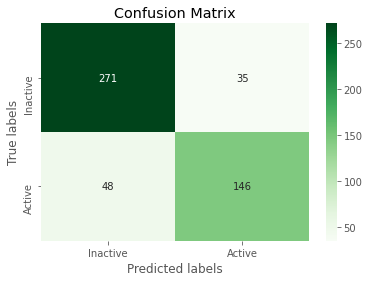

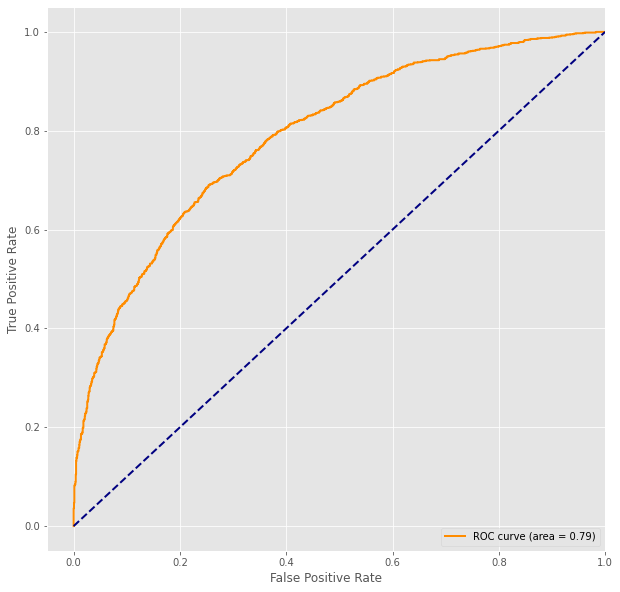

Proportion actives in test: 0.38666666666666666 Proportion actives in train: 0.38755555555555554
Metrics with size 3000, testing set
NER: 0.828, Sensitivity or recall: 0.755, Specificity: 0.900, Precision: 0.826, Correctly classified: 0.844, MCC: 0.667


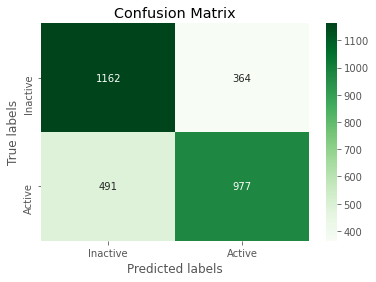

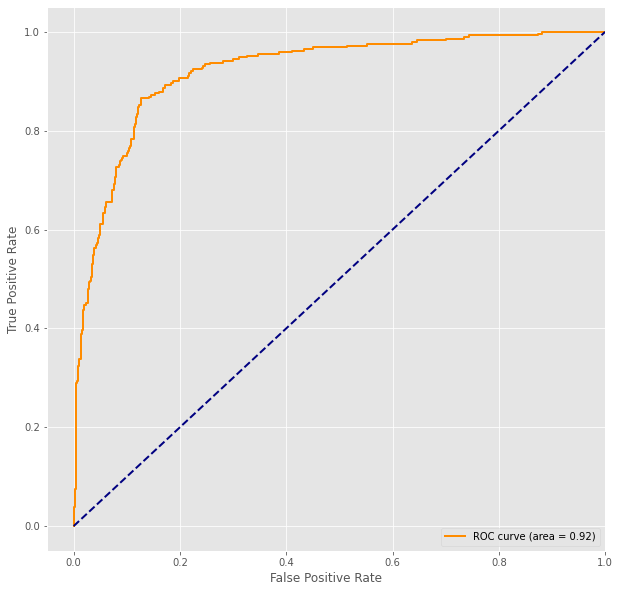

Metrics with size 3000, validation set
NER: 0.716, Sensitivity or recall: 0.636, Specificity: 0.795, Precision: 0.749, Correctly classified: 0.717, MCC: 0.437


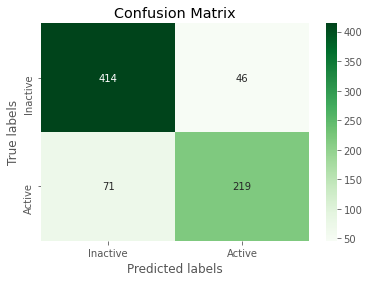

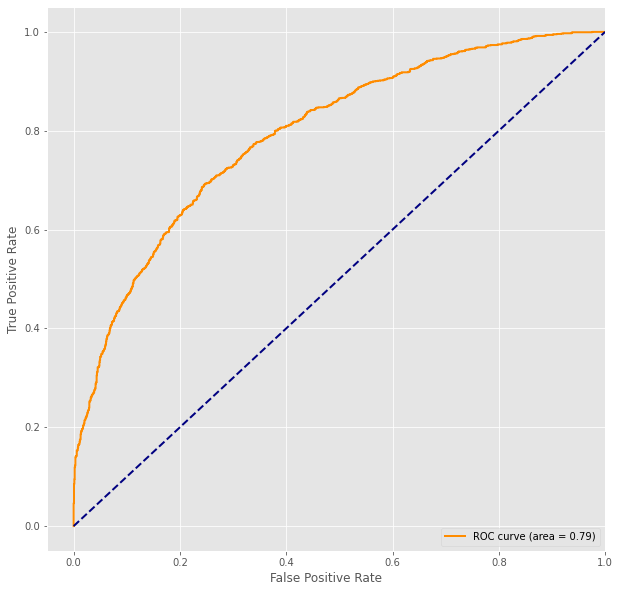

Proportion actives in test: 0.3872 Proportion actives in train: 0.3874666666666667
Metrics with size 5000, testing set
NER: 0.860, Sensitivity or recall: 0.812, Specificity: 0.909, Precision: 0.849, Correctly classified: 0.871, MCC: 0.727


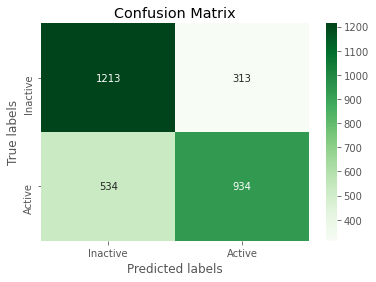

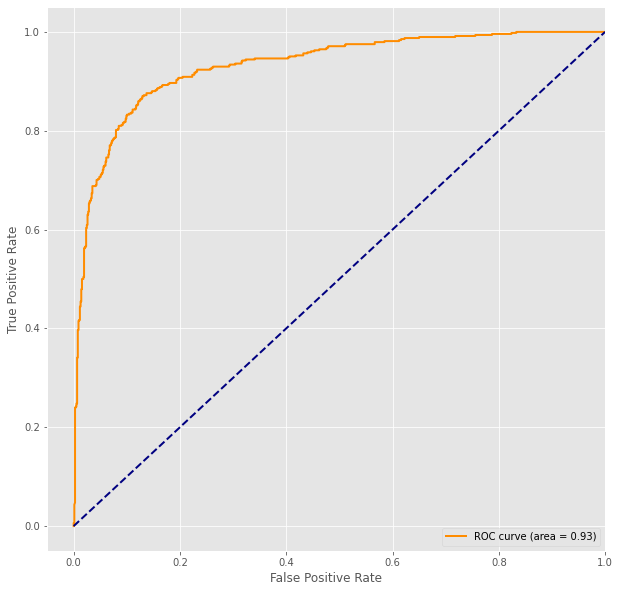

Metrics with size 5000, validation set
NER: 0.727, Sensitivity or recall: 0.681, Specificity: 0.773, Precision: 0.743, Correctly classified: 0.728, MCC: 0.456


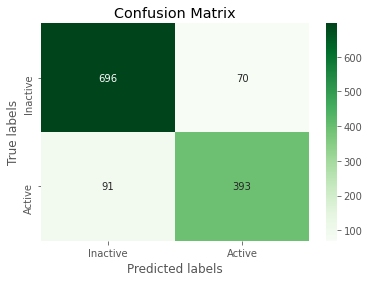

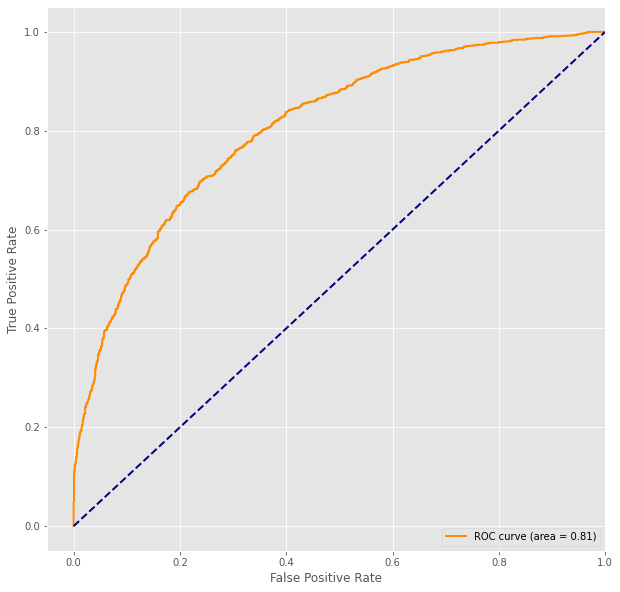

Proportion actives in test: 0.38742857142857146 Proportion actives in train: 0.38742857142857146
Metrics with size 7000, testing set
NER: 0.866, Sensitivity or recall: 0.764, Specificity: 0.968, Precision: 0.938, Correctly classified: 0.889, MCC: 0.768


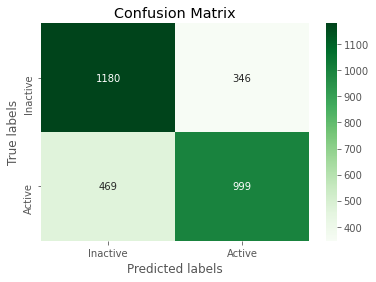

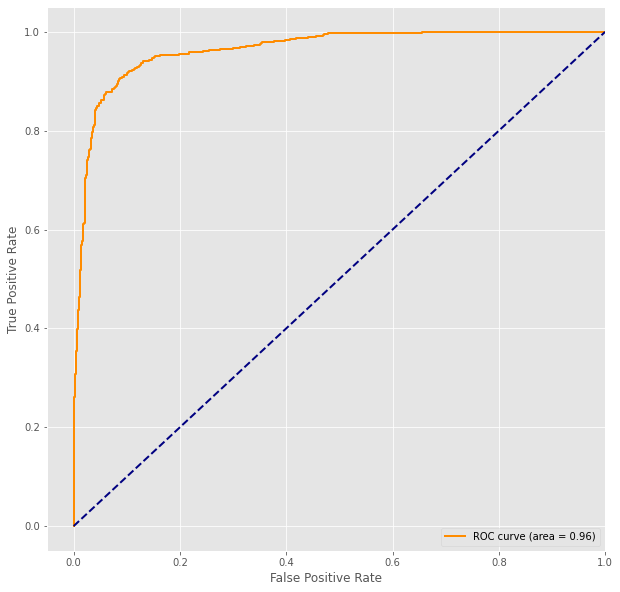

Metrics with size 7000, validation set
NER: 0.700, Sensitivity or recall: 0.507, Specificity: 0.893, Precision: 0.820, Correctly classified: 0.704, MCC: 0.435


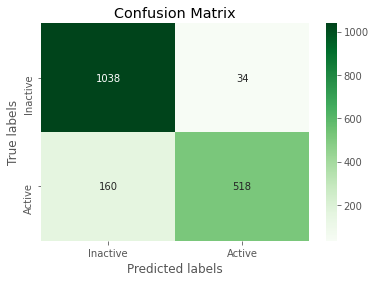

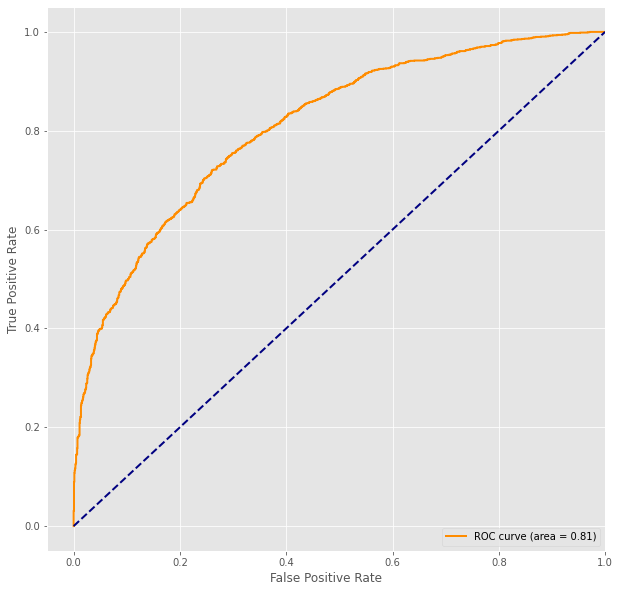

Proportion actives in test: 0.38768577494692147 Proportion actives in train: 0.38740268931351735
Metrics with size 9420, testing set
NER: 0.943, Sensitivity or recall: 0.922, Specificity: 0.964, Precision: 0.942, Correctly classified: 0.948, MCC: 0.890


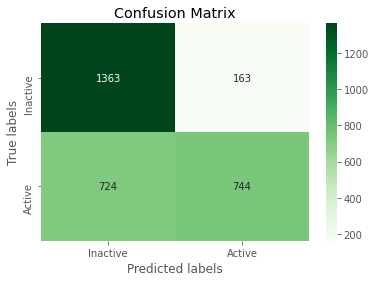

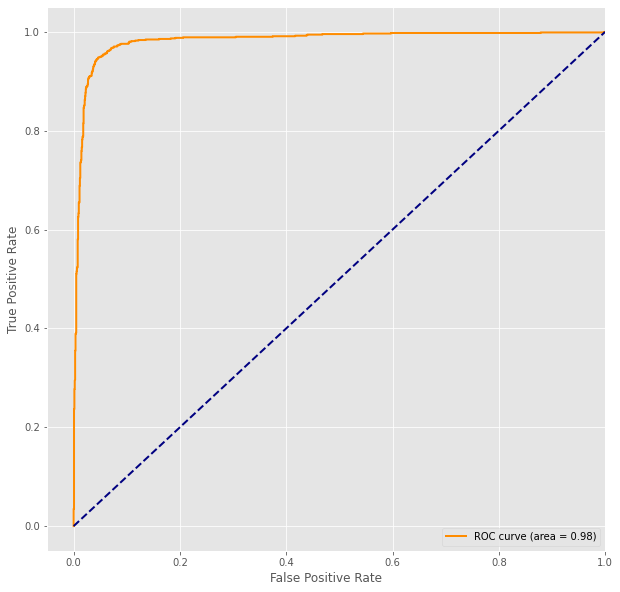

Metrics with size 9420, validation set
NER: 0.739, Sensitivity or recall: 0.659, Specificity: 0.820, Precision: 0.779, Correctly classified: 0.741, MCC: 0.486


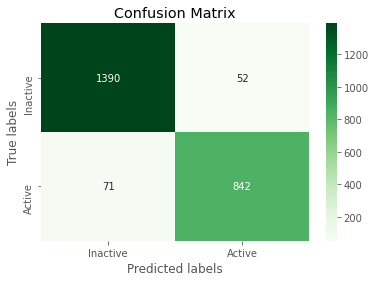

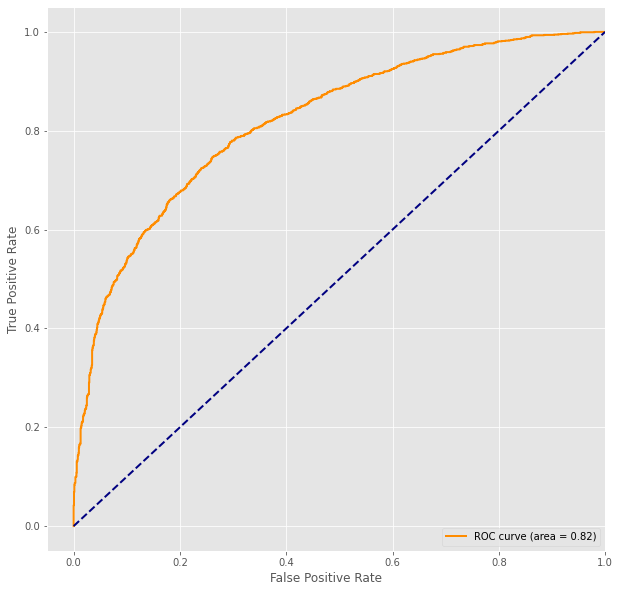

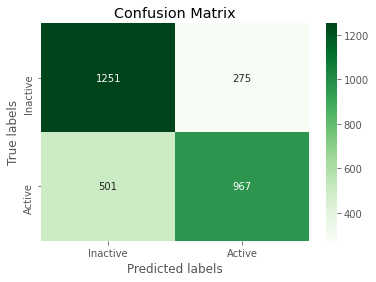

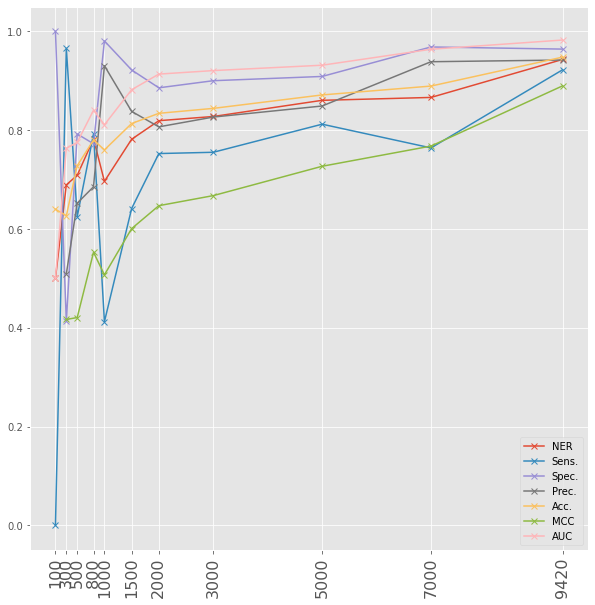

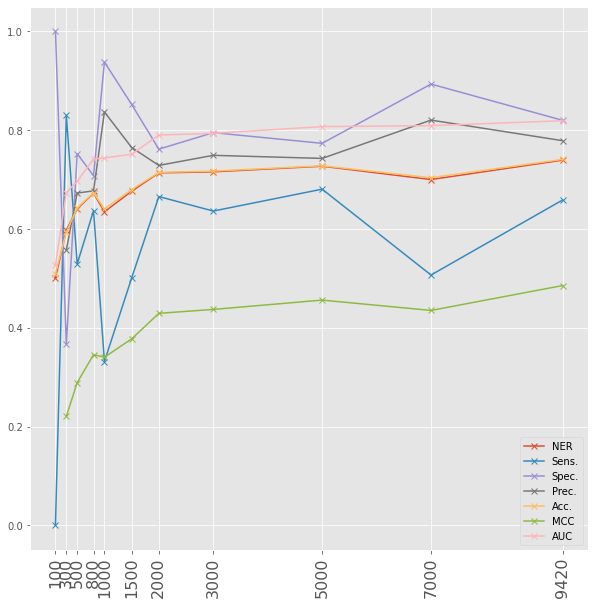

In [35]:
isoform_name = "3a4"
# non-balanced, 3a4 set
active_rate = len(np.where(labels_3a4 == 1)[0])/len(labels_3a4)
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path, isoform_name, labels_3a4, features_shared, features_only_3a4, labels_validation_3a4, "nonbalanced")

Proportion actives in test: 0.52 Proportion actives in train: 0.49333333333333335
Metrics with size 100, testing set
NER: 0.583, Sensitivity or recall: 1.000, Specificity: 0.167, Precision: 0.565, Correctly classified: 0.600, MCC: 0.307


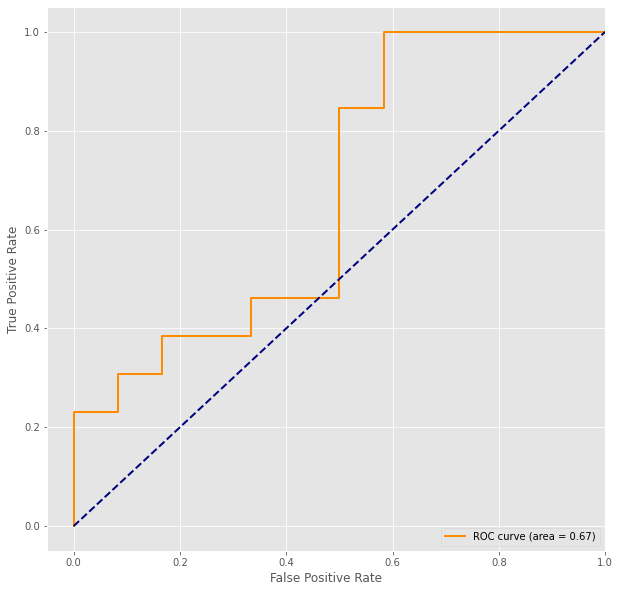

Metrics with size 100, validation set
NER: 0.519, Sensitivity or recall: 0.975, Specificity: 0.064, Precision: 0.500, Correctly classified: 0.510, MCC: 0.093


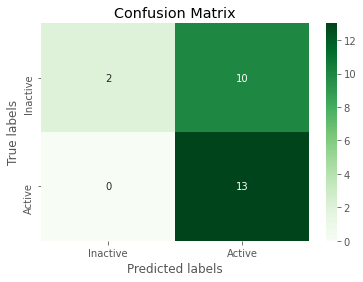

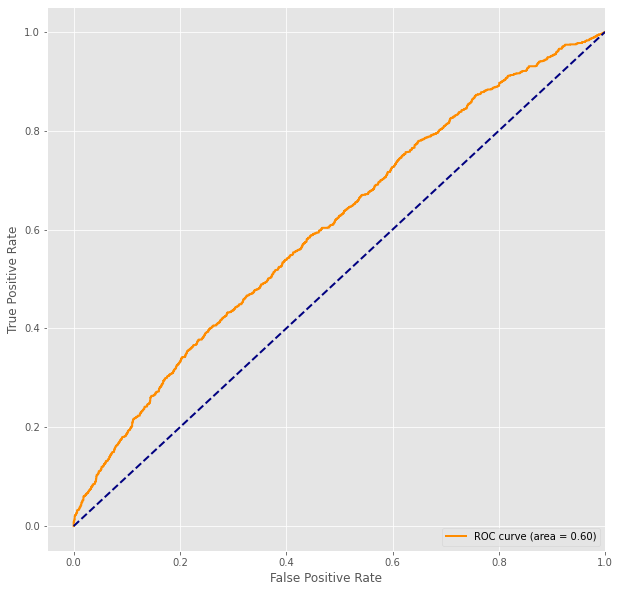

Proportion actives in test: 0.49333333333333335 Proportion actives in train: 0.5022222222222222
Metrics with size 300, testing set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.493, Correctly classified: 0.493, MCC: nan


<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


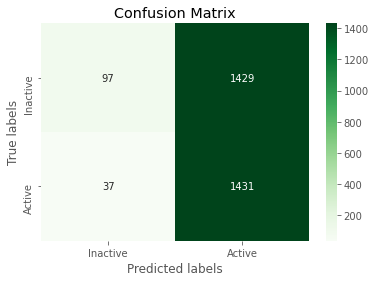

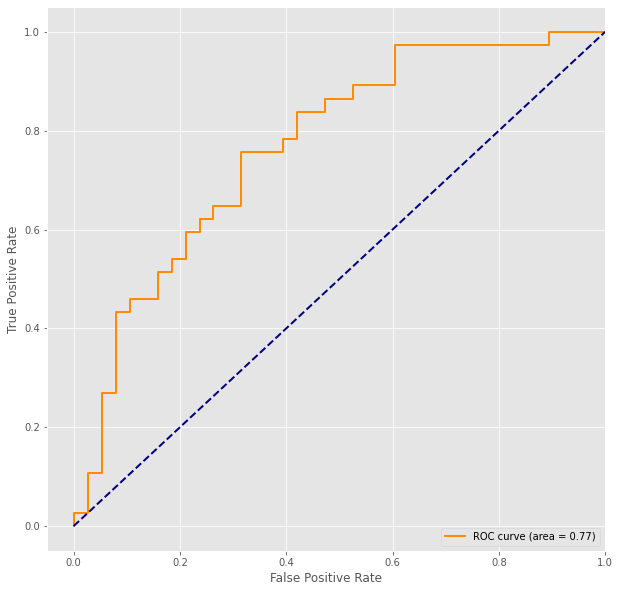

Metrics with size 300, validation set
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.490, Correctly classified: 0.490, MCC: nan


<ipython-input-29-a4ae85189bd1>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


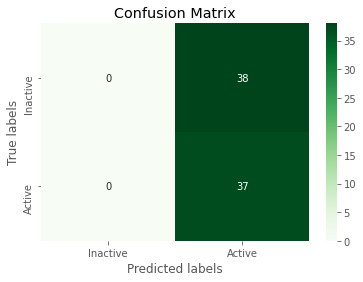

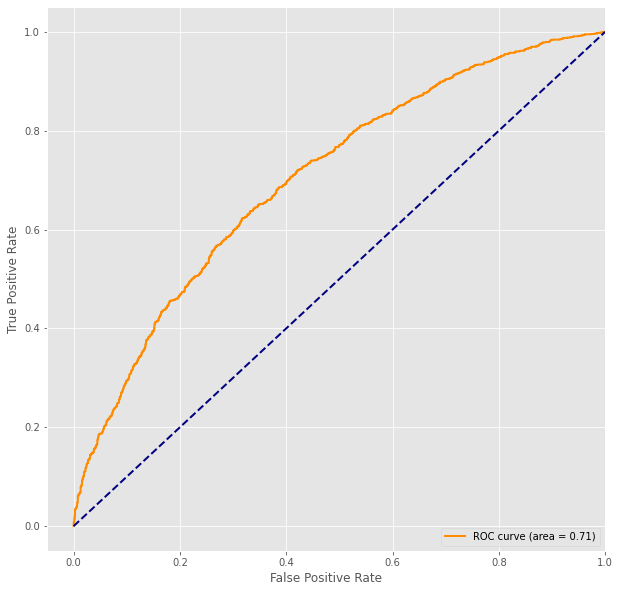

Proportion actives in test: 0.504 Proportion actives in train: 0.49866666666666665
Metrics with size 500, testing set
NER: 0.642, Sensitivity or recall: 0.349, Specificity: 0.935, Precision: 0.846, Correctly classified: 0.640, MCC: 0.351


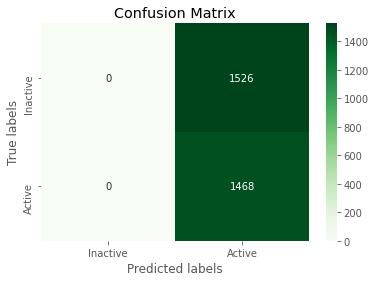

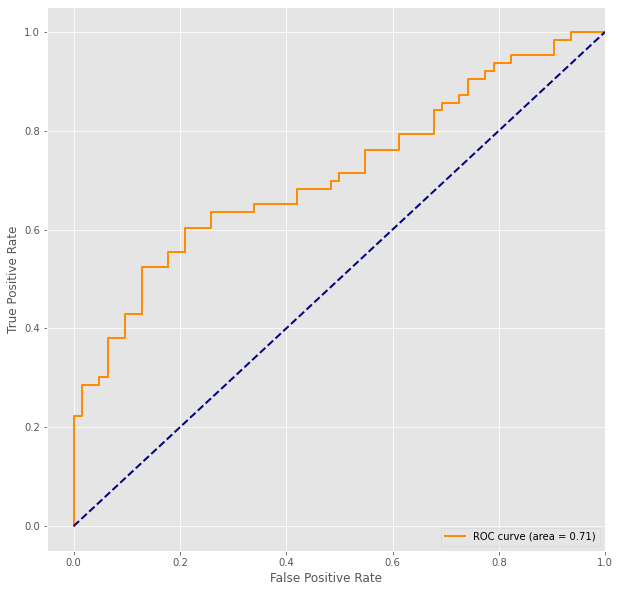

Metrics with size 500, validation set
NER: 0.619, Sensitivity or recall: 0.339, Specificity: 0.899, Precision: 0.763, Correctly classified: 0.624, MCC: 0.288


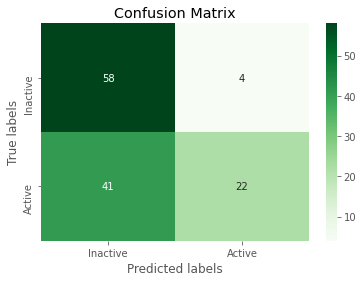

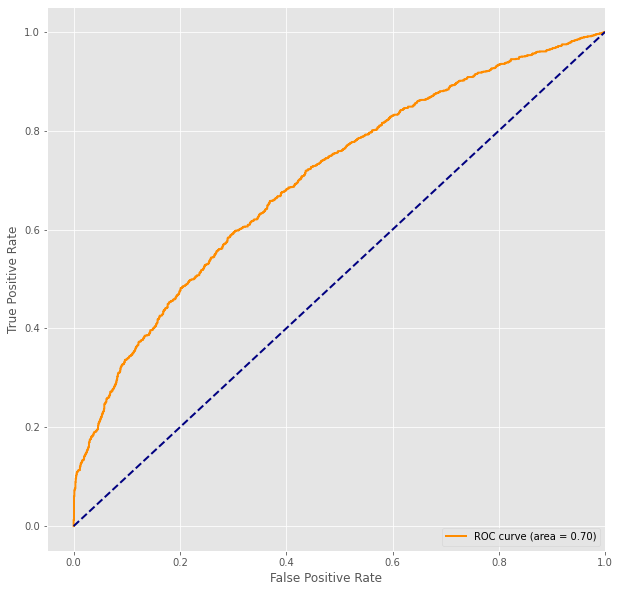

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 800, testing set
NER: 0.745, Sensitivity or recall: 0.670, Specificity: 0.820, Precision: 0.788, Correctly classified: 0.745, MCC: 0.496


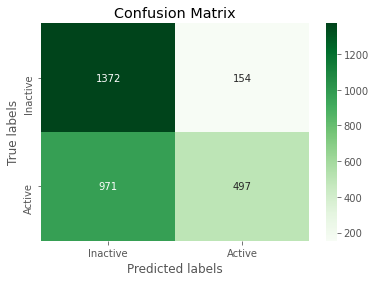

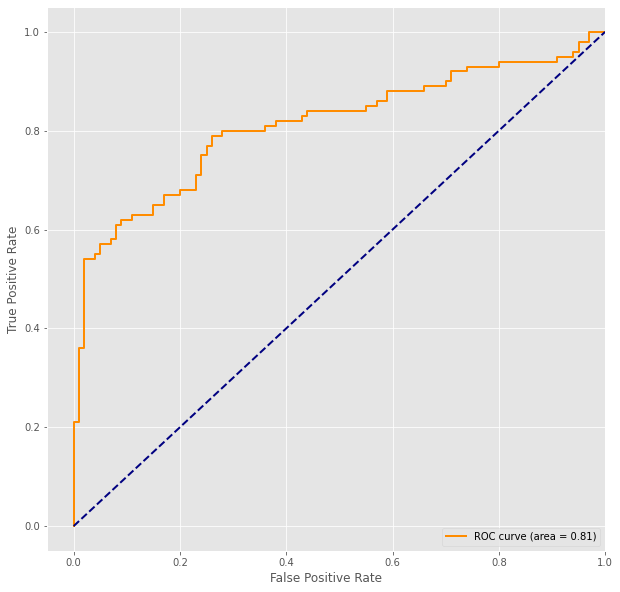

Metrics with size 800, validation set
NER: 0.682, Sensitivity or recall: 0.649, Specificity: 0.716, Precision: 0.687, Correctly classified: 0.683, MCC: 0.366


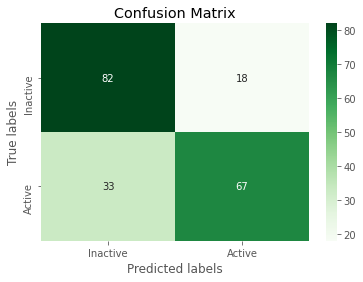

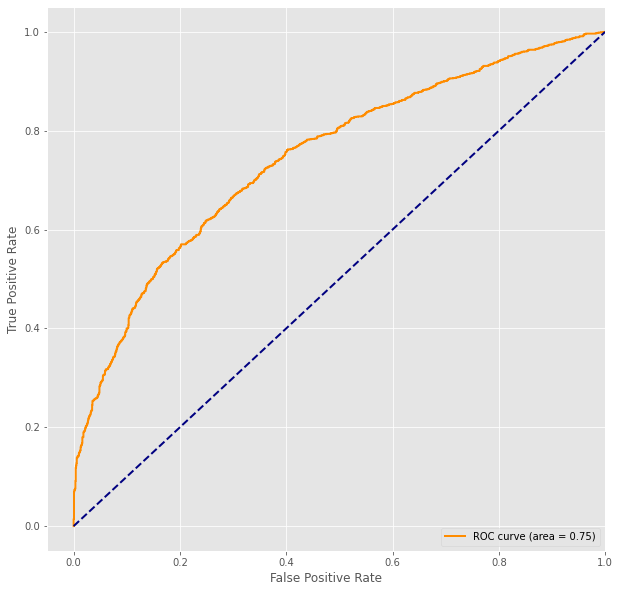

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 1000, testing set
NER: 0.808, Sensitivity or recall: 0.792, Specificity: 0.824, Precision: 0.818, Correctly classified: 0.808, MCC: 0.616


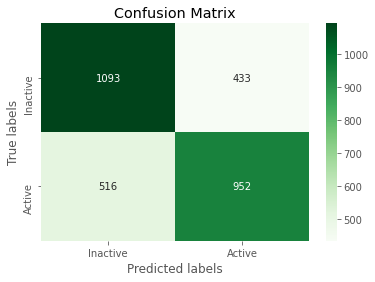

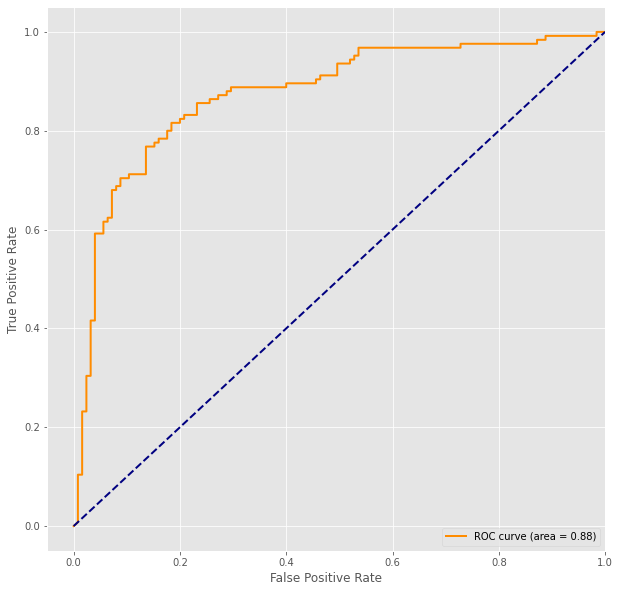

Metrics with size 1000, validation set
NER: 0.688, Sensitivity or recall: 0.692, Specificity: 0.685, Precision: 0.679, Correctly classified: 0.688, MCC: 0.377


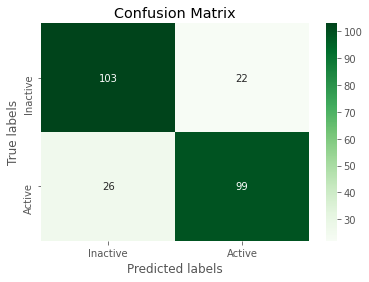

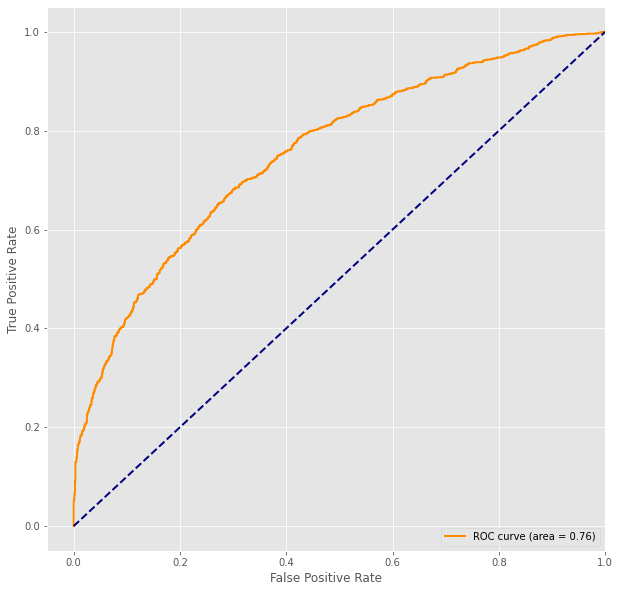

Proportion actives in test: 0.5013333333333333 Proportion actives in train: 0.49955555555555553
Metrics with size 1500, testing set
NER: 0.582, Sensitivity or recall: 0.165, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.581, MCC: 0.299


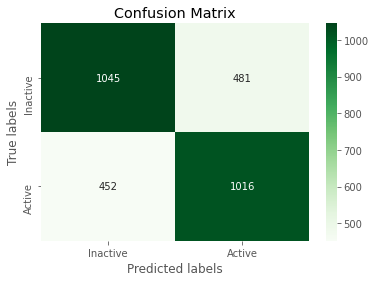

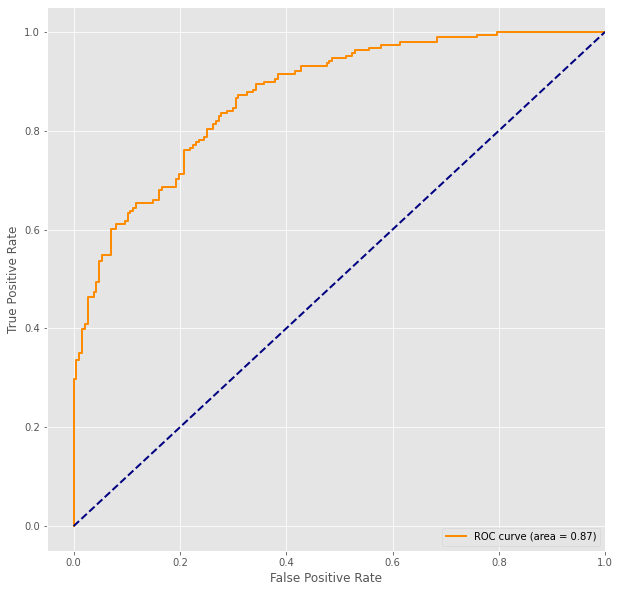

Metrics with size 1500, validation set
NER: 0.558, Sensitivity or recall: 0.122, Specificity: 0.993, Precision: 0.947, Correctly classified: 0.566, MCC: 0.237


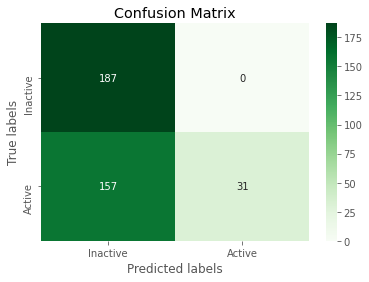

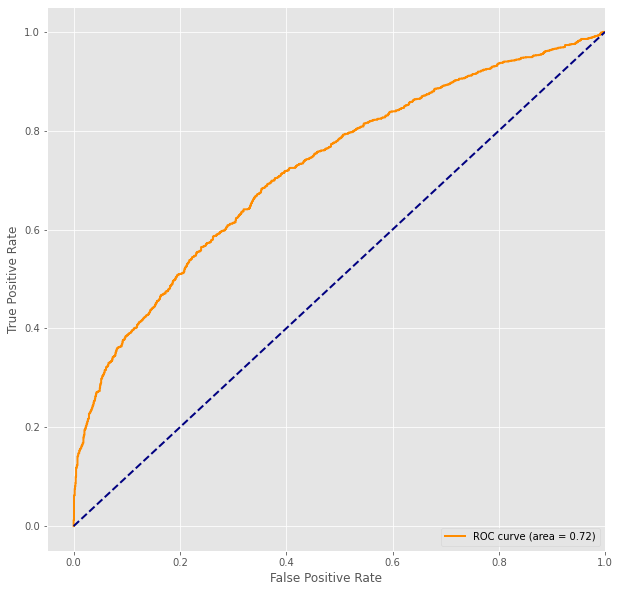

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 2000, testing set
NER: 0.804, Sensitivity or recall: 0.756, Specificity: 0.852, Precision: 0.836, Correctly classified: 0.804, MCC: 0.611


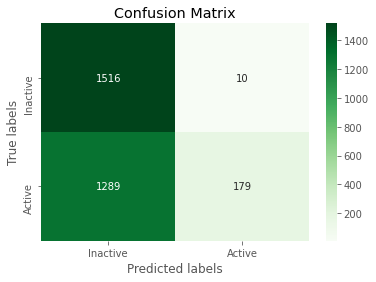

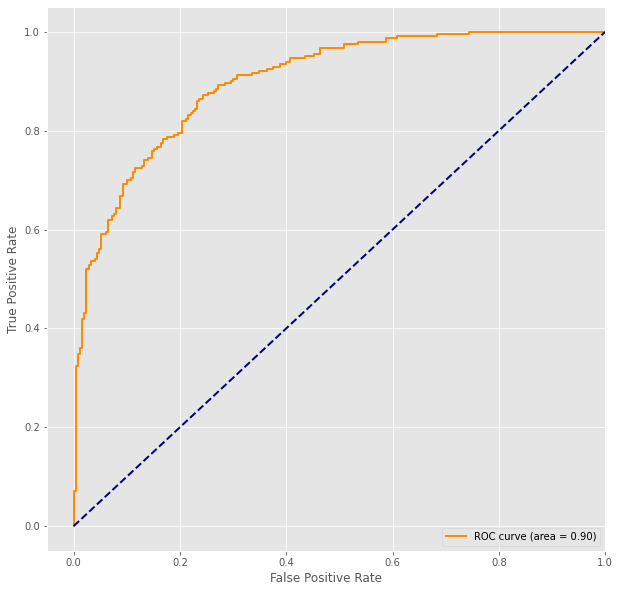

Metrics with size 2000, validation set
NER: 0.706, Sensitivity or recall: 0.656, Specificity: 0.756, Precision: 0.721, Correctly classified: 0.707, MCC: 0.415


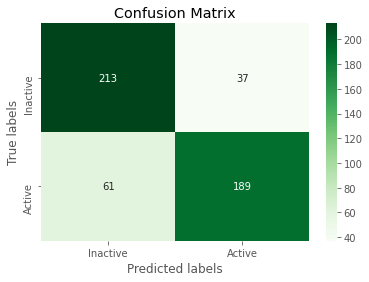

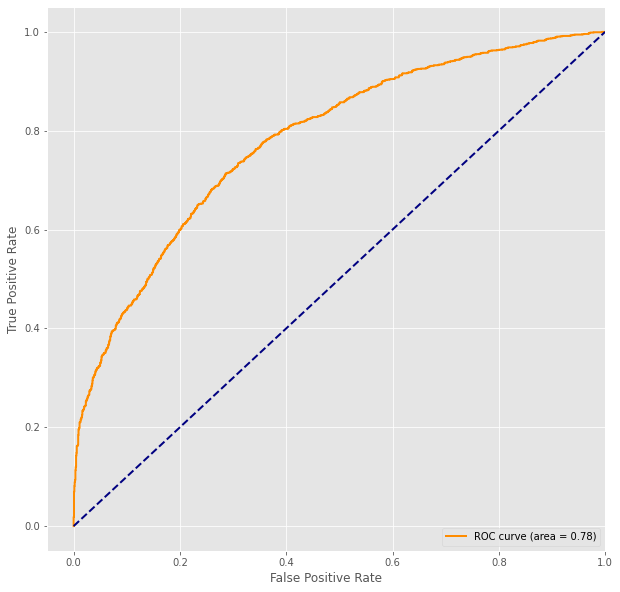

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 3000, testing set
NER: 0.811, Sensitivity or recall: 0.707, Specificity: 0.915, Precision: 0.892, Correctly classified: 0.811, MCC: 0.635


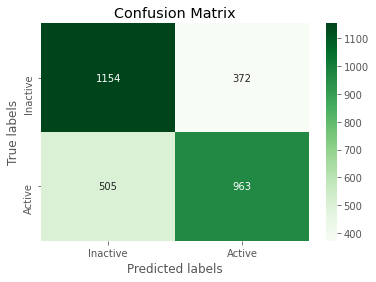

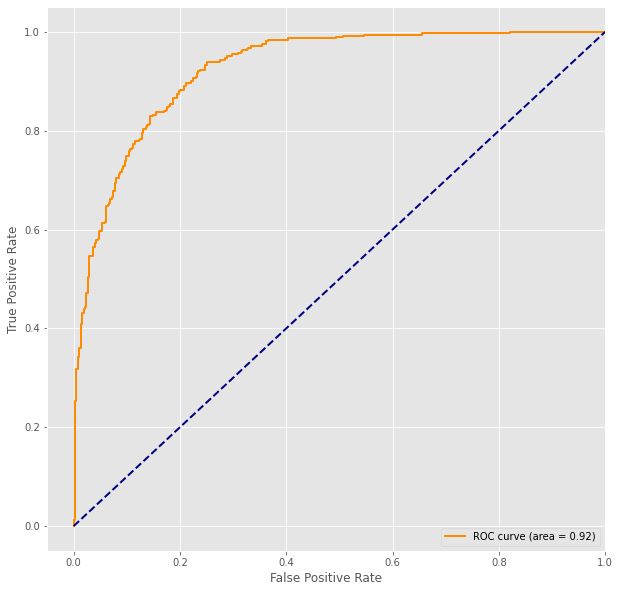

Metrics with size 3000, validation set
NER: 0.686, Sensitivity or recall: 0.511, Specificity: 0.860, Precision: 0.779, Correctly classified: 0.689, MCC: 0.397


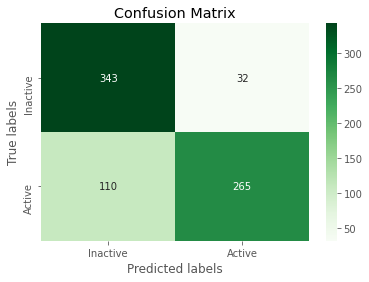

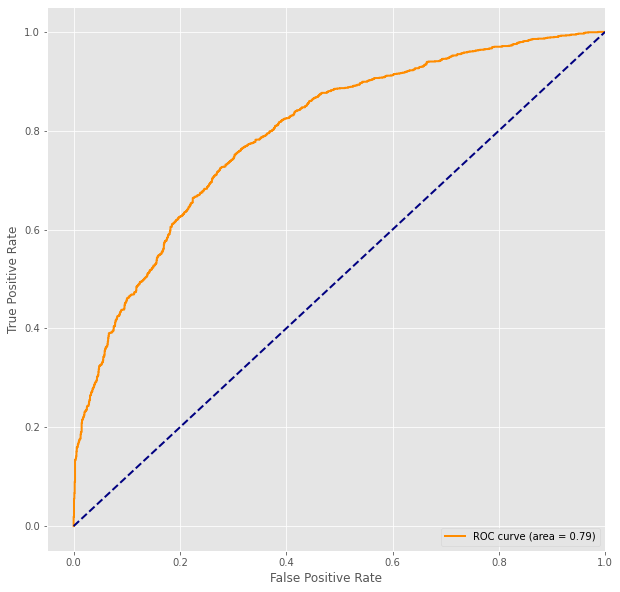

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 5000, testing set
NER: 0.887, Sensitivity or recall: 0.912, Specificity: 0.862, Precision: 0.869, Correctly classified: 0.887, MCC: 0.775


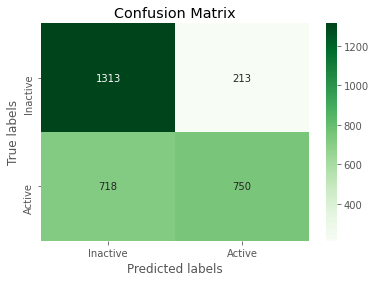

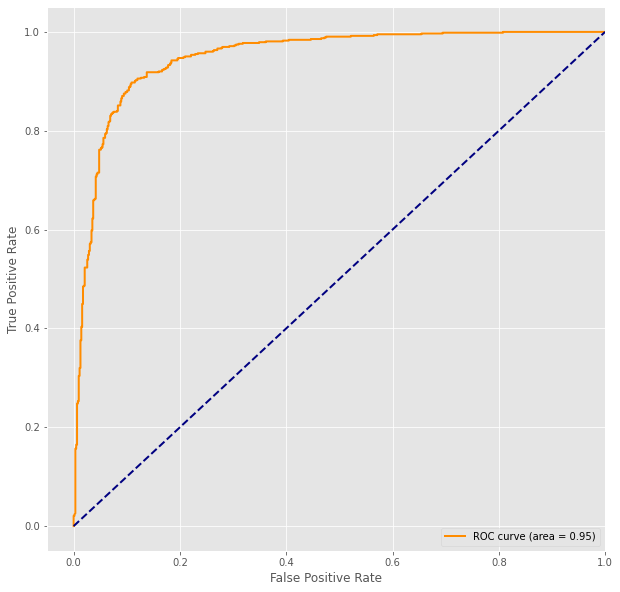

Metrics with size 5000, validation set
NER: 0.733, Sensitivity or recall: 0.779, Specificity: 0.687, Precision: 0.706, Correctly classified: 0.732, MCC: 0.468


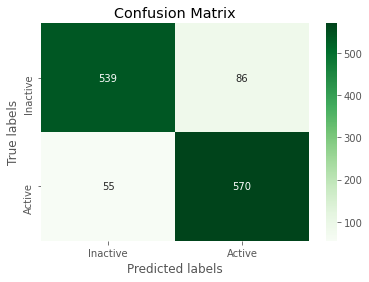

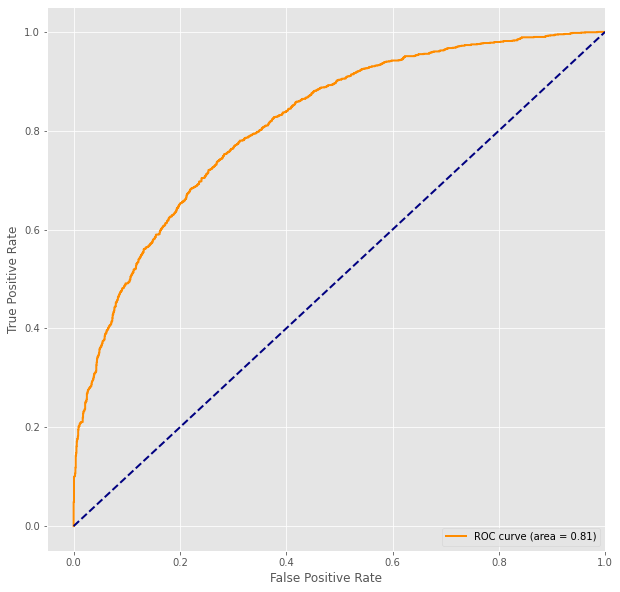

Proportion actives in test: 0.5 Proportion actives in train: 0.5
Metrics with size 7000, testing set
NER: 0.905, Sensitivity or recall: 0.885, Specificity: 0.925, Precision: 0.921, Correctly classified: 0.905, MCC: 0.810


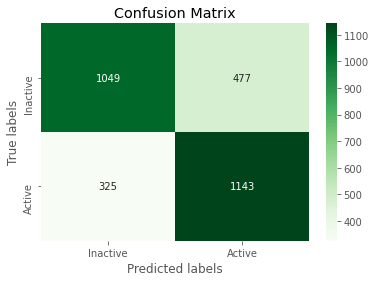

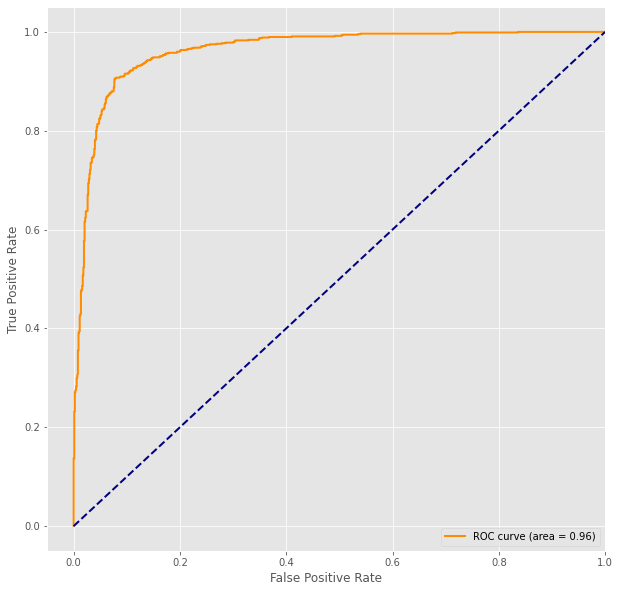

Metrics with size 7000, validation set
NER: 0.743, Sensitivity or recall: 0.700, Specificity: 0.786, Precision: 0.759, Correctly classified: 0.744, MCC: 0.488


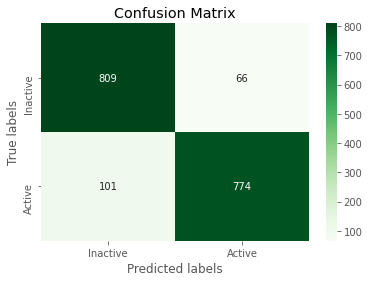

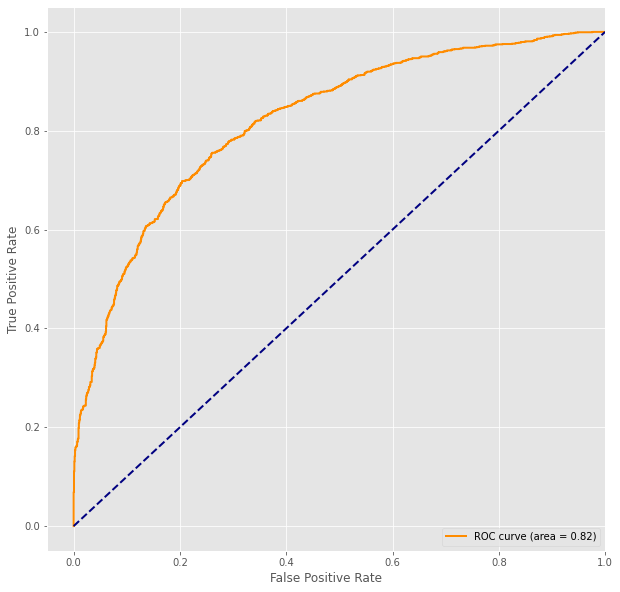

Proportion actives in test: 0.38768577494692147 Proportion actives in train: 0.38740268931351735
Metrics with size 9420, testing set
NER: 0.949, Sensitivity or recall: 0.963, Specificity: 0.935, Precision: 0.903, Correctly classified: 0.946, MCC: 0.888


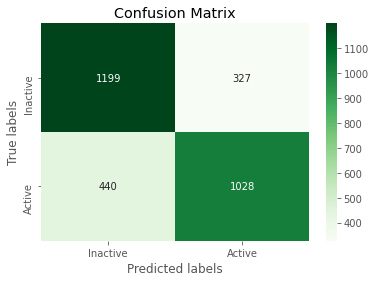

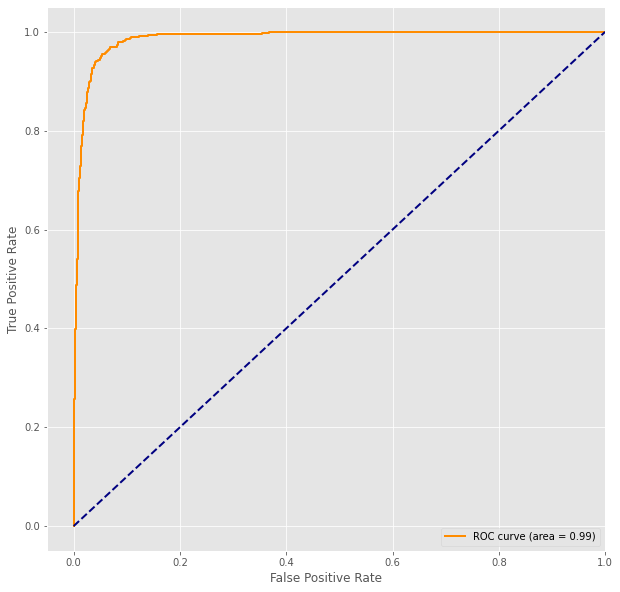

Metrics with size 9420, validation set
NER: 0.739, Sensitivity or recall: 0.744, Specificity: 0.734, Precision: 0.729, Correctly classified: 0.739, MCC: 0.478


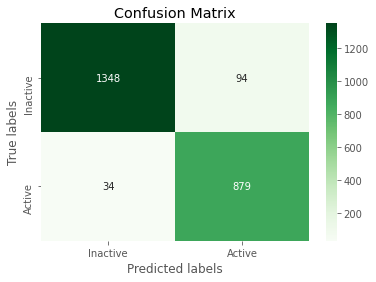

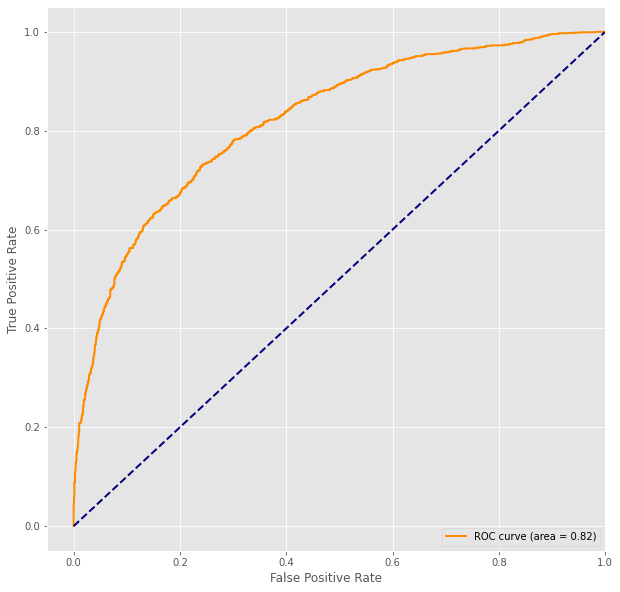

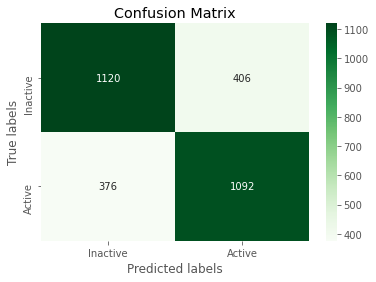

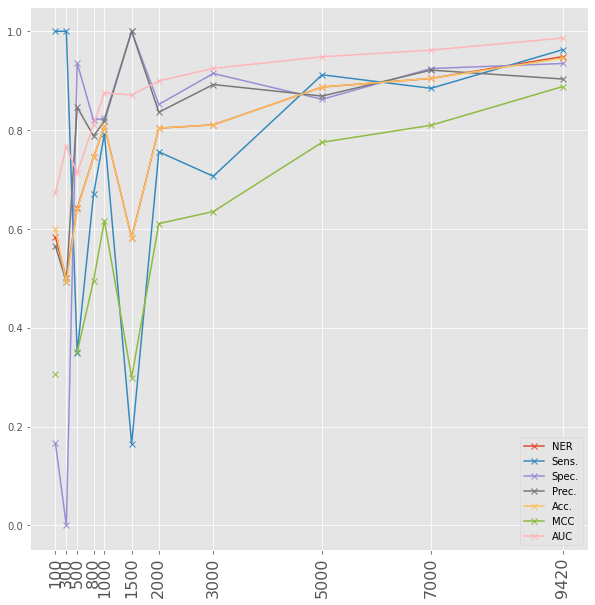

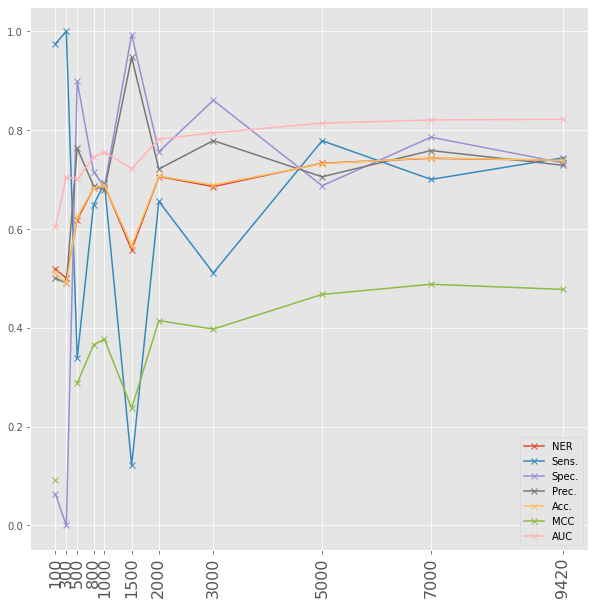

In [37]:
# balanced, 3a4 set
active_rate = 0.5
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path_balanced, isoform_name, labels_3a4, features_shared, features_only_3a4, labels_validation_3a4, "balanced")